### Import packages 

In [1]:
# Import packages
import numpy as np
import os
import pandas as pd
import numpy as np

import datetime as dt

from pandas.plotting import parallel_coordinates

from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import networkx as nx
import seaborn as sns

from pathlib import Path
from math import ceil

from sklearn.preprocessing import StandardScaler, OneHotEncoder, normalize
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from yellowbrick.cluster import KElbowVisualizer

from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView
from sompy.visualization.mapview import View2D
import sompy

import warnings
warnings.filterwarnings('ignore')

### Definition of Functions

In [2]:
def plotKElbow(cluster,df,metric):
    visualizer = KElbowVisualizer(cluster, k=(2,8), metric=metric, timings=False,locate_elbowbool=False)
    visualizer.fit(df)        
    visualizer.show()  

In [3]:
def kmeans_cluster(df,n_clust):
    kmclust = KMeans(n_clusters=n_clust, init='k-means++', n_init=15, random_state=1)
    df_labels = kmclust.fit_predict(df)
    return df_labels

In [4]:
def gmm_cluster(data, nclust):
    gmm=GaussianMixture(n_components=nclust, init_params='kmeans', random_state=0)
    gmm.fit(data)
    clust_labels = gmm.predict(data)
    return(clust_labels)

In [5]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        #ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("{} Cluster Means - {} Clusters".format(label_columns, len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
        
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.figure(figsize=(12, 2))
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()
    

In [6]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        hclabels = cluster.fit_predict(df) #get cluster labels
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

In [7]:
def scaling(X_train, X_test):
    """
    Scaler of variables using the training set 
    """
    standard = StandardScaler().fit(X_train)
    
    return standard.transform(X_train) , standard.transform(X_test)

### Importing Data

#### Describe, explore and assess the data

In [8]:
#To import orders dataset
orders = pd.read_csv('orders.csv')
orders.head()

order_id  user_id  order_number  order_dow  order_hour_of_day  \
0   2425083    49125             1          2                 18   
1   1944304   162867             1          3                 17   
2   1201011   147243            14          0                 16   
3   1906860   195275            81          1                 11   
4   2766469    58222             3          6                 11   

   days_since_prior_order  
0                     NaN  
1                     NaN  
2                     3.0  
3                     3.0  
4                     6.0

In [9]:
#To import departments dataset
dep = pd.read_csv('departments.csv')
dep.head()

department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

In [10]:
#To import order product dataset
order_prod = pd.read_csv('order_products.csv', usecols=['order_id', 'product_id','add_to_cart_order', 'reordered'])
order_prod.head()

order_id  product_id  add_to_cart_order  reordered
0        10          24                  1          1
1        10          83                  2          1
2        10          16                  3          0
3        10          24                  4          1
4        10          83                  5          1

In [11]:
#To import product label mapping
products = pd.read_csv('products.csv')
products.head()

product_id  department_id                product_name
0          61             19               cookies cakes
1         104             13           spices seasonings
2          94              7                         tea
3          38              1                frozen meals
4           5             13  marinades meat preparation

In [12]:
#To merge dep and products tables, joined on 'department_id'
prod_dep = pd.merge(dep, products, how='left', on='department_id')
prod_dep.head()

department_id department  product_id          product_name
0              1     frozen          38          frozen meals
1              1     frozen         116        frozen produce
2              1     frozen         119        frozen dessert
3              1     frozen          79          frozen pizza
4              1     frozen          58  frozen breads doughs

In [13]:
#To merge dep and products tables, joined on 'order_id'
ord_ordProd = pd.merge(orders, order_prod, how='left', on='order_id' )
ord_ordProd.head()

order_id  user_id  order_number  order_dow  order_hour_of_day  \
0   2425083    49125             1          2                 18   
1   2425083    49125             1          2                 18   
2   2425083    49125             1          2                 18   
3   2425083    49125             1          2                 18   
4   2425083    49125             1          2                 18   

   days_since_prior_order  product_id  add_to_cart_order  reordered  
0                     NaN          17                  1          0  
1                     NaN          91                  2          0  
2                     NaN          36                  3          0  
3                     NaN          83                  4          0  
4                     NaN          83                  5          0

In [14]:
#To merge the two merged tables
df = pd.merge(prod_dep, ord_ordProd, how='left', on='product_id').\
    drop(["product_id", "department_id"], axis=1)
df.head()

department  product_name  order_id  user_id  order_number  order_dow  \
0     frozen  frozen meals   2236391   110030             3          4   
1     frozen  frozen meals   2236391   110030             3          4   
2     frozen  frozen meals   2236391   110030             3          4   
3     frozen  frozen meals   1948583   171390            11          6   
4     frozen  frozen meals     96161    37753             1          0   

   order_hour_of_day  days_since_prior_order  add_to_cart_order  reordered  
0                 15                    11.0                  1          1  
1                 15                    11.0                  2          0  
2                 15                    11.0                  3          0  
3                 16                    30.0                 16          0  
4                 11                     NaN                  1          0

In [15]:
df.head()

department  product_name  order_id  user_id  order_number  order_dow  \
0     frozen  frozen meals   2236391   110030             3          4   
1     frozen  frozen meals   2236391   110030             3          4   
2     frozen  frozen meals   2236391   110030             3          4   
3     frozen  frozen meals   1948583   171390            11          6   
4     frozen  frozen meals     96161    37753             1          0   

   order_hour_of_day  days_since_prior_order  add_to_cart_order  reordered  
0                 15                    11.0                  1          1  
1                 15                    11.0                  2          0  
2                 15                    11.0                  3          0  
3                 16                    30.0                 16          0  
4                 11                     NaN                  1          0

In [16]:
#To return a tuple representing the dimensionality of the DataFrame df
df.shape

(2019501, 10)

In [17]:
#To return the dtypes in the DataFrame
#In this way, we can start looking better at our data
df.dtypes

department                 object
product_name               object
order_id                    int64
user_id                     int64
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
add_to_cart_order           int64
reordered                   int64
dtype: object

In [18]:
# Get modes and unique values
df.astype(object).describe()

department  product_name  order_id  user_id  order_number  order_dow  \
count     2019501       2019501   2019501  2019501       2019501    2019501   
unique         21           134    200000   105273           100          7   
top       produce  fresh fruits    790903   176478             1          0   
freq       588996        226039       137      460        124342     391831   

        order_hour_of_day  days_since_prior_order  add_to_cart_order  \
count             2019501               1895159.0            2019501   
unique                 24                    31.0                137   
top                    10                     7.0                  1   
freq               173306                214126.0             200000   

        reordered  
count     2019501  
unique          2  
top             1  
freq      1190986

In [19]:
#To count distinct observations over requested axis.
df.nunique()

department                    21
product_name                 134
order_id                  200000
user_id                   105273
order_number                 100
order_dow                      7
order_hour_of_day             24
days_since_prior_order        31
add_to_cart_order            137
reordered                      2
dtype: int64

In [20]:
#To summary statistics for all variables
df.describe(include='all')

department  product_name      order_id       user_id  order_number  \
count     2019501       2019501  2.019501e+06  2.019501e+06  2.019501e+06   
unique         21           134           NaN           NaN           NaN   
top       produce  fresh fruits           NaN           NaN           NaN   
freq       588996        226039           NaN           NaN           NaN   
mean          NaN           NaN  1.707013e+06  1.030673e+05  1.715138e+01   
std           NaN           NaN  9.859832e+05  5.949117e+04  1.752576e+01   
min           NaN           NaN  1.000000e+01  2.000000e+00  1.000000e+00   
25%           NaN           NaN  8.526490e+05  5.158400e+04  5.000000e+00   
50%           NaN           NaN  1.705004e+06  1.026900e+05  1.100000e+01   
75%           NaN           NaN  2.559031e+06  1.546000e+05  2.400000e+01   
max           NaN           NaN  3.421080e+06  2.062090e+05  1.000000e+02   

           order_dow  order_hour_of_day  days_since_prior_order  \
count   2.019501e+06       2.019501e+06            1.895159e+06   
unique           NaN                NaN                     NaN   
top              NaN                NaN                     NaN   
freq             NaN                NaN                     NaN   
mean    2.735367e+00       1.343948e+01            1.138603e+01   
std     2.093882e+00       4.241008e+00            8.970980e+00   
min     0.000000e+00       0.000000e+00            0.000000e+00   
25%     1.000000e+00       1.000000e+01            5.000000e+00   
50%     3.000000e+00       1.300000e+01            8.000000e+00   
75%     5.000000e+00       1.600000e+01            1.500000e+01   
max     6.000000e+00       2.300000e+01            3.000000e+01   

        add_to_cart_order     reordered  
count        2.019501e+06  2.019501e+06  
unique                NaN           NaN  
top                   NaN           NaN  
freq                  NaN           NaN  
mean         8.363173e+00  5.897427e-01  
std          7.150059e+00  4.918804e-01  
min          1.000000e+00  0.000000e+00  
25%          3.000000e+00  0.000000e+00  
50%          6.000000e+00  1.000000e+00  
75%          1.100000e+01  1.000000e+00  
max          1.370000e+02  1.000000e+00

In [21]:
#To check product frequencies
df['product_name'].value_counts()

fresh fruits                  226039
fresh vegetables              212611
packaged vegetables fruits    109596
yogurt                         90751
packaged cheese                61502
                               ...  
kitchen supplies                 561
baby bath body care              515
baby accessories                 504
beauty                           387
frozen juice                     279
Name: product_name, Length: 134, dtype: int64

### Data visualization and Data Understanding

Here, we are going to show some visualizations to understand and to have more insights from the data.

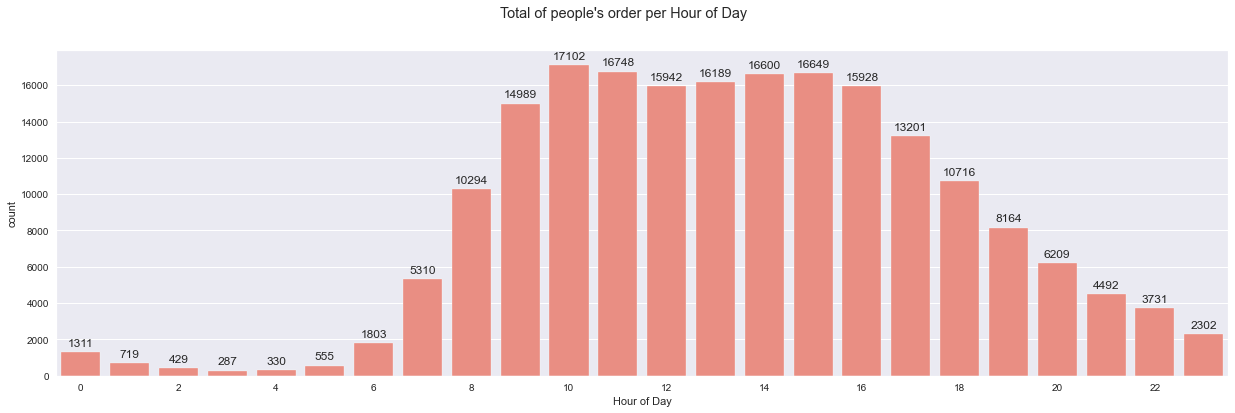

In [23]:
#To see the total of people's order per Hour of Day
sns.set_style("darkgrid")
plt.figure(figsize=(21, 6))

splot = sns.countplot(x='order_hour_of_day', data=orders, color='salmon')

ax = plt.gca()

ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=2))

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'),(p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

title = "Total of people's order per Hour of Day"
plt.xlabel('Hour of Day')
plt.suptitle(title)

plt.show()

Text(0.5, 0.98, "Total of people's order per Day of the Week")

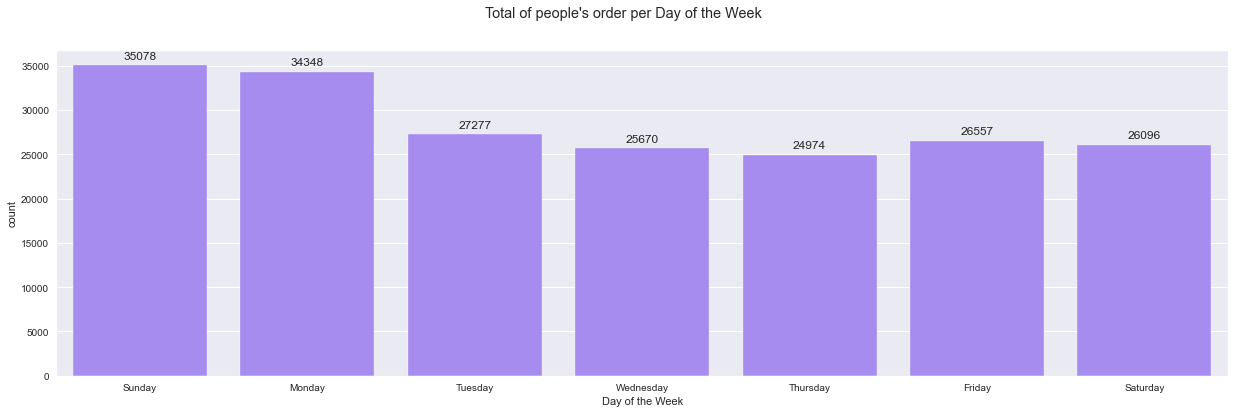

In [24]:
#To see the total of people's order per Day of the Week
plt.figure(figsize=(21, 6))

splot = sns.countplot(x='order_dow', data=orders, color='#9E7BFF')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'),(p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

x = np.array([0,1,2,3,4,5,6])
my_xticks = ['Sunday','Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday']
plt.xticks(x,my_xticks)
    
title = "Total of people's order per Day of the Week"
plt.xlabel('Day of the Week')
plt.suptitle(title)

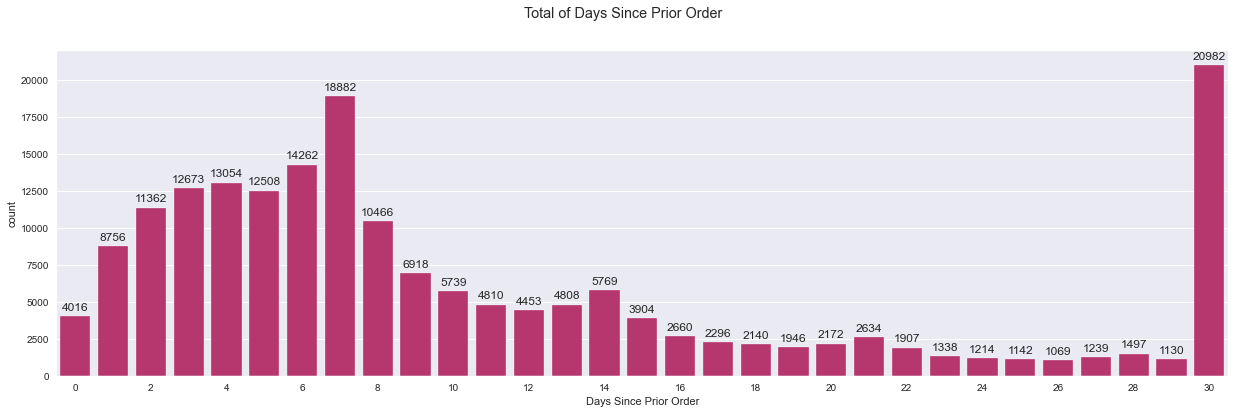

In [25]:
#To see the total of Days Since Prior Order
plt.figure(figsize=(21, 6))

splot = sns.countplot(x='days_since_prior_order', data=orders, color='#CA226B')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'),(p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
ax = plt.gca()

ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=2))


title = "Total of Days Since Prior Order"
plt.xlabel('Days Since Prior Order')
plt.suptitle(title)

plt.show()

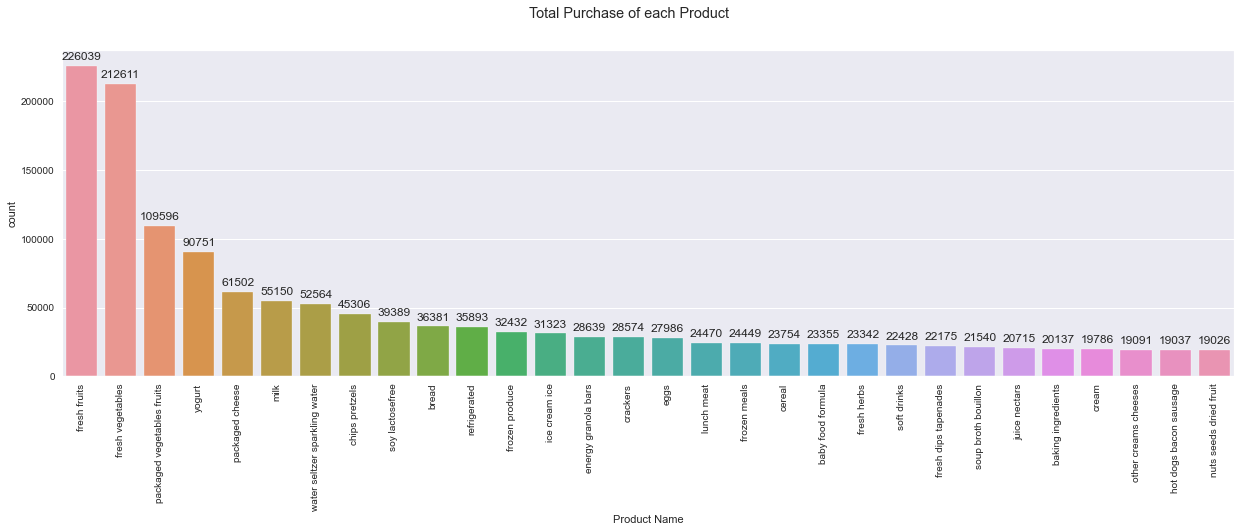

In [26]:
#To overall most bought products top 30
plt.figure(figsize=(21, 6))

splot = sns.countplot(x='product_name', data=df, order = df['product_name'].value_counts().head(30).index)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'),(p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
title = "Total Purchase of each Product"
plt.xlabel('Product Name')
plt.suptitle(title)
plt.xticks(rotation=90)

plt.show()

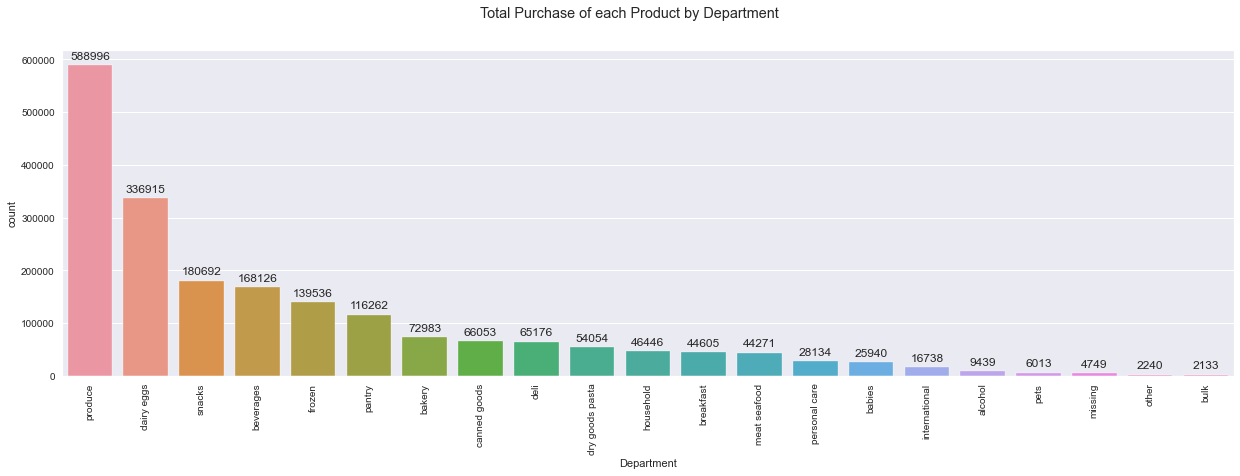

In [27]:
#To overall most bought products but by department
plt.figure(figsize=(21, 6))

splot = sns.countplot(x='department', data=df, order = df['department'].value_counts().index)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'),(p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

title = "Total Purchase of each Product by Department"
plt.xlabel('Department')
plt.suptitle(title)
plt.xticks(rotation=90)

plt.show()

In [28]:
#To group by department and to have the sum of reordered products
df_grp = df.groupby(['department'])['reordered'].sum().reset_index().sort_values(by=['reordered'], ascending=False)

In [29]:
#To group by user_id and have the count of order_id
df_grp2 = df.groupby(['user_id'])['order_id'].count().reset_index().rename(columns={'order_id':'number_of_orders'})

In [30]:
#To group by order_id and have the product name. In other words, we want the number of products for each order_id
df_grp3 = df.groupby(['order_id'])['product_name'].count().reset_index().rename(columns={'product_name':'number_of_products'})

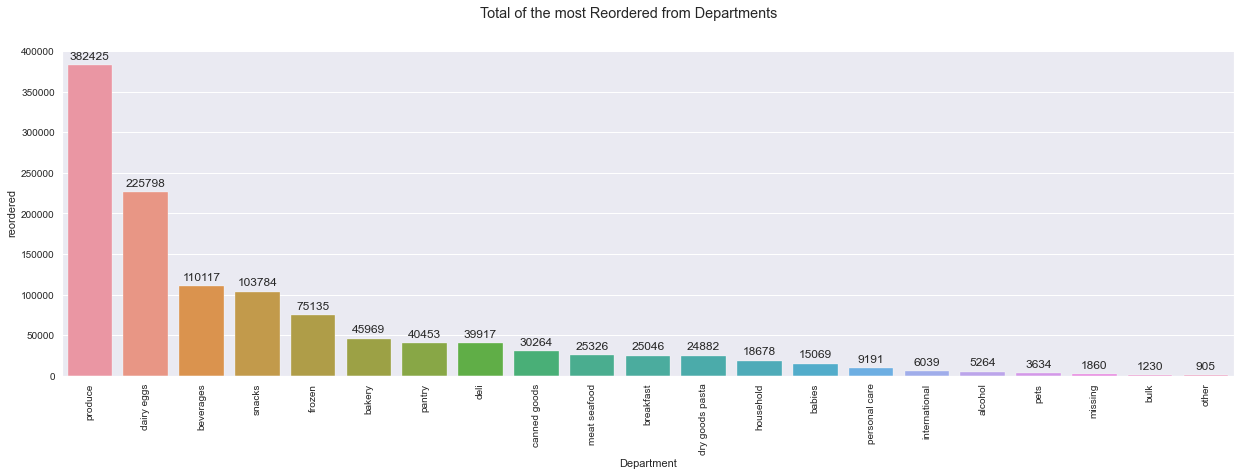

In [31]:
#To show the most reordered from departments
#plt.figure(figsize=(15,8))
plt.figure(figsize=(21, 6))

splot = sns.barplot(x='department', y='reordered',data=df_grp, order=df_grp['department'])

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'),(p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
title = "Total of the most Reordered from Departments"
plt.xlabel('Department')
plt.suptitle(title)
plt.xticks(rotation=90)

plt.show()

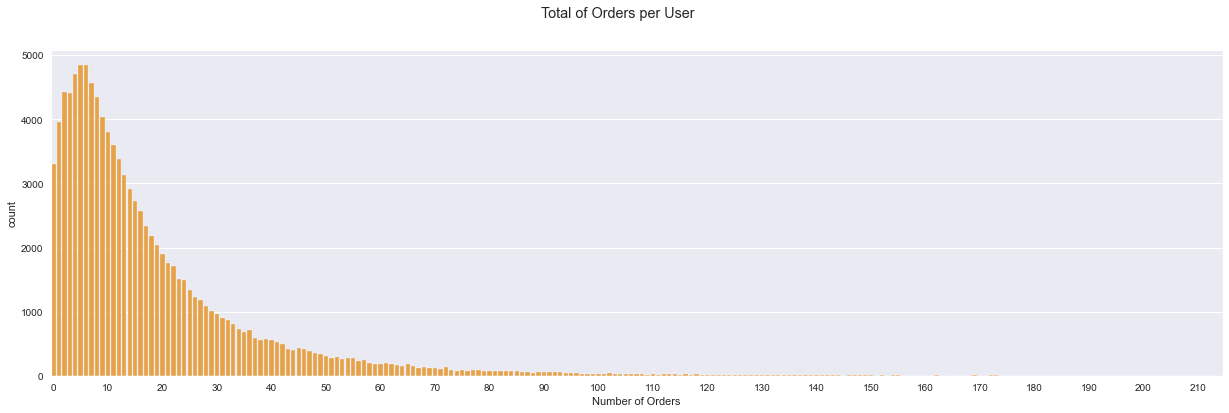

In [32]:
#To show the number of orders per user
plt.figure(figsize=(21, 6))

splot = sns.countplot(x='number_of_orders', data=df_grp2, color='#FFA62F')

ax = plt.gca()

ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10))

title = "Total of Orders per User"
plt.xlabel('Number of Orders')
plt.suptitle(title)

plt.show()

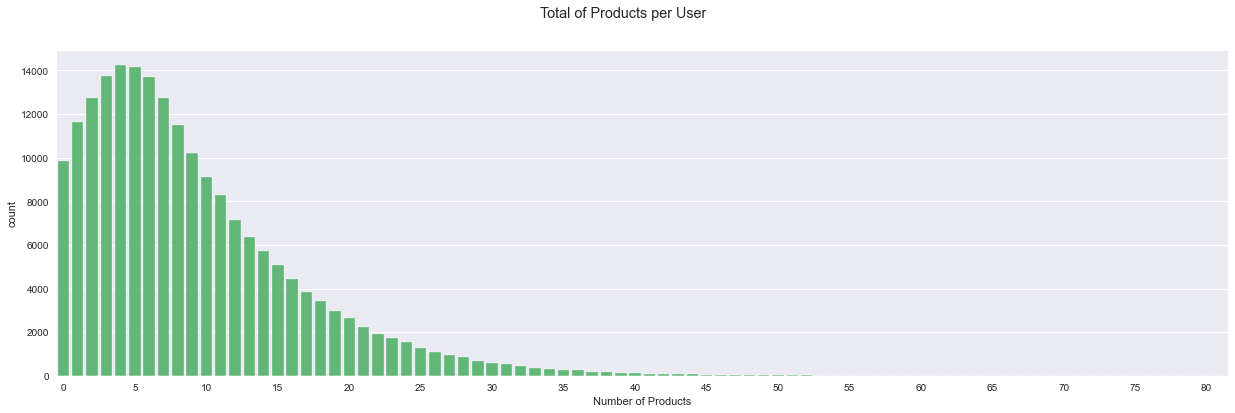

In [33]:
#To show the number of products per order
plt.figure(figsize=(21, 6))

splot = sns.countplot(x='number_of_products', data=df_grp3, color='#54C571')

ax = plt.gca()

ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5))

title = "Total of Products per User"
plt.xlabel('Number of Products')
plt.suptitle(title)

plt.show()

In [34]:
#To order by order_id and product name and to obain the sum of add_to_cart_order of each group
basket = df.groupby(['order_id', 'product_name'])['add_to_cart_order'].sum().unstack().reset_index().fillna(0).set_index('order_id')

In [35]:
#Function to retunr 0 or 1
#Enconding funciton
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

In [36]:
#To apply the function to the basket dataframe
basket_sets = basket.applymap(encode_units)

In [79]:
proportion_column = basket_sets.sum(axis=0)/len(basket_sets)

In [38]:
#To rename columns, reset the index and sort values of the proportional_column dataframe
proportion_column = proportion_column.reset_index().rename(columns={0:'proportion_of_orders'}).sort_values(by=['proportion_of_orders'], ascending=False)

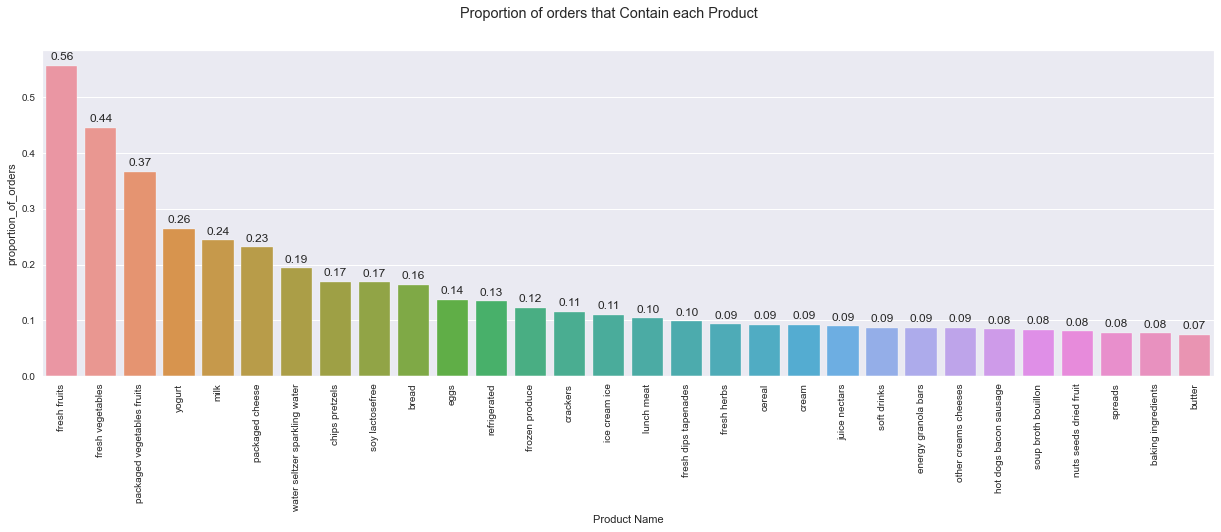

In [39]:
#To show the proportion of orders that contain each product
plt.figure(figsize=(21, 6))

splot = sns.barplot(x='product_name', y='proportion_of_orders',data=proportion_column, order=proportion_column['product_name'].head(30))

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'),(p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

title = "Proportion of orders that Contain each Product"
plt.xlabel('Product Name')
plt.suptitle(title)
plt.xticks(rotation=90)

plt.show()
    

### Data Preparation and Data Preprocessing

In [40]:
#Checking for missing data
df.isnull().sum()

department                     0
product_name                   0
order_id                       0
user_id                        0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    124342
add_to_cart_order              0
reordered                      0
dtype: int64

In [41]:
#To check the total number of Nan values that we have in our dataset.
df.isna().sum().sum()

124342

In [42]:
#Total percentage of Nan values in our dataset
df.isnull().sum() / len(df) * 100

department                0.000000
product_name              0.000000
order_id                  0.000000
user_id                   0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    6.157066
add_to_cart_order         0.000000
reordered                 0.000000
dtype: float64

As we can see above there are some Nan values. Although this value is over 3%, we decided to eliminate it.

In [43]:
#To delete the nan value of the 'koi_kepmag' feature
df = df.dropna()

In [44]:
#To check if we don't have more None values
df.isna().sum().sum()

0

In [45]:
#To return boolean Series denoting duplicate rows
#As we can see, we have some duplicates
df.loc[df.duplicated(keep=False), :]

Empty DataFrame
Columns: [department, product_name, order_id, user_id, order_number, order_dow, order_hour_of_day, days_since_prior_order, add_to_cart_order, reordered]
Index: []

In [46]:
#To return a tuple representing the dimensionality of the DataFrame df
df.shape

(1895159, 10)

In [47]:
#To groupby by all columns except 'add_to_cart_order' and have only the line with the max value of add_to_cart_order 
df = df.groupby(by=['order_id', 'department', 'product_name', 'user_id', 'order_number','order_dow', 'order_hour_of_day', 'days_since_prior_order','reordered'])['add_to_cart_order'].max().reset_index()

In [48]:
#To return the first 5 rows
df.head()

order_id    department        product_name  user_id  order_number  \
0        10        babies   baby food formula   135442             4   
1        10  canned goods  canned meals beans   135442             4   
2        10    dairy eggs               cream   135442             4   
3        10  meat seafood        meat counter   135442             4   
4        10       produce        fresh fruits   135442             4   

   order_dow  order_hour_of_day  days_since_prior_order  reordered  \
0          6                  8                     8.0          1   
1          6                  8                     8.0          0   
2          6                  8                     8.0          1   
3          6                  8                     8.0          0   
4          6                  8                     8.0          1   

   add_to_cart_order  
0                  9  
1                 10  
2                 12  
3                 13  
4                  7

In [49]:
#To substitute the name of the column
df.rename(columns={'add_to_cart_order':'quantity'})

order_id    department        product_name  user_id  order_number  \
0              10        babies   baby food formula   135442             4   
1              10  canned goods  canned meals beans   135442             4   
2              10    dairy eggs               cream   135442             4   
3              10  meat seafood        meat counter   135442             4   
4              10       produce        fresh fruits   135442             4   
...           ...           ...                 ...      ...           ...   
1469994   3421080    dairy eggs                eggs    52726             2   
1469995   3421080    dairy eggs                milk    52726             2   
1469996   3421080        frozen       ice cream ice    52726             2   
1469997   3421080       produce         fresh herbs    52726             2   
1469998   3421080       produce    fresh vegetables    52726             2   

         order_dow  order_hour_of_day  days_since_prior_order  reordered  \
0                6                  8                     8.0          1   
1                6                  8                     8.0          0   
2                6                  8                     8.0          1   
3                6                  8                     8.0          0   
4                6                  8                     8.0          1   
...            ...                ...                     ...        ...   
1469994          1                 11                     2.0          1   
1469995          1                 11                     2.0          1   
1469996          1                 11                     2.0          1   
1469997          1                 11                     2.0          0   
1469998          1                 11                     2.0          0   

         quantity  
0               9  
1              10  
2              12  
3              13  
4               7  
...           ...  
1469994         6  
1469995         1  
1469996         2  
1469997         5  
1469998         4  

[1469999 rows x 10 columns]

In [50]:
#To return a tuple representing the dimensionality of the DataFrame df
df.shape

(1469999, 10)

In [51]:
#To return the dtypes in the DataFrame
#In this way, we can start looking better at our data
df.dtypes

order_id                    int64
department                 object
product_name               object
user_id                     int64
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
reordered                   int64
add_to_cart_order           int64
dtype: object

### Data Exploration

In [52]:
#To separate the non_metric_features from metric_features
non_metric_features = df.select_dtypes(include="object").columns.to_list()

metric_features = df.columns.drop(non_metric_features).to_list()
metric_features.remove('reordered')

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f8338b70700>
Using auto colorbar locator on colorbar
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f8338b70700>
Setting pcolormesh


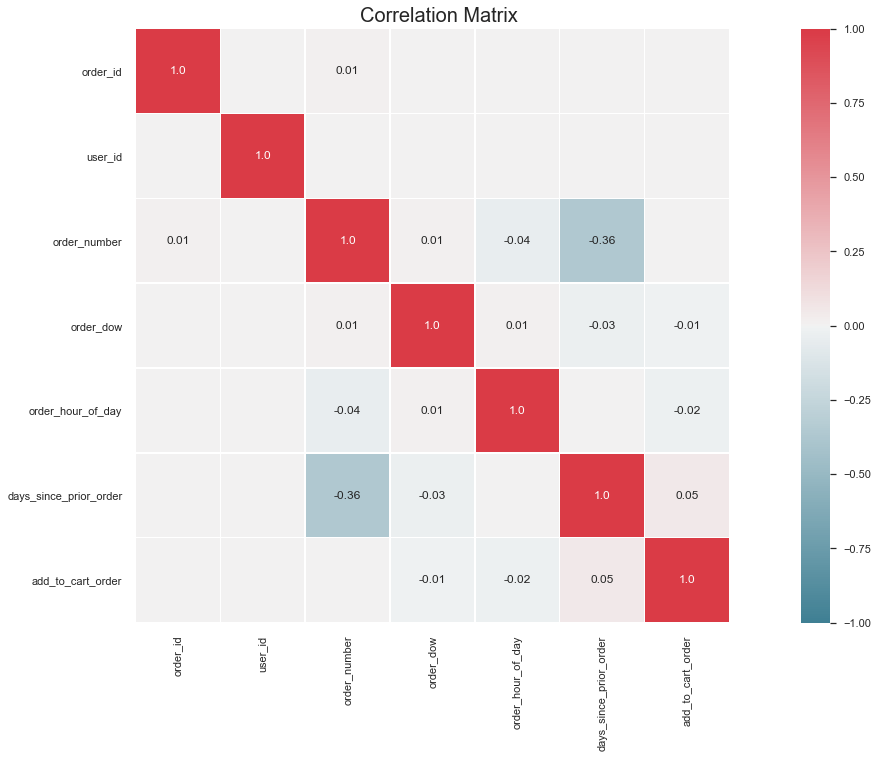

In [55]:
#To see the correlation between the matric variables
# Prepare figure
fig = plt.figure(figsize=(20, 10))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df[metric_features].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values)
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
           fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95, left = -0.09)
fig.suptitle("Correlation Matrix", fontsize= 20)

plt.show()

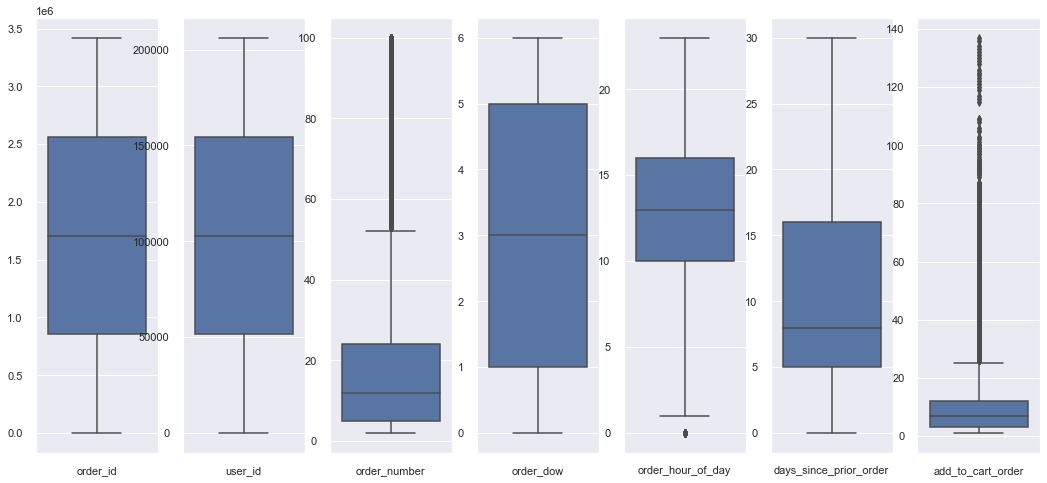

In [54]:
#To do the boxplots
sns.set()

plot_features = df[metric_features].columns
fig, axes = plt.subplots(1, len(plot_features), figsize=(18,8))

j=0
k=1

for i in zip(axes, plot_features):
    sns.boxplot(data=df[metric_features].iloc[:,j:k], ax=i[0])
    
    j=j+1
    k=k+1
    
plt.show()

In [56]:
#As we can see, we have some variables with outliers 
#So we are going to apply the IQR
#Function to do IQR 
def outlier(data_column):
    df1 = df[data_column]

    q1 = df1.quantile(0.25)
    q3 = df1.quantile(0.75)

    iqr = q3 - q1

    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr)
    
    return lower_bound, upper_bound

In [57]:
#Here, we are going to see how many outliers exists
total_outliers = 0

for metric in metric_features:
    lower_bound, upper_bound = outlier(metric)
    out = len(df[(df[metric] < lower_bound) | (df[metric] > upper_bound)])
    total_outliers += out
    

In [58]:
#As we can see, there are not a lot of outliers
#However, we will not remove them
total_data_outliers = total_outliers/len(df) * 100
total_data_outliers 

9.439598258230108

In [59]:
#To return the first 5 rows.
df.head()

order_id    department        product_name  user_id  order_number  \
0        10        babies   baby food formula   135442             4   
1        10  canned goods  canned meals beans   135442             4   
2        10    dairy eggs               cream   135442             4   
3        10  meat seafood        meat counter   135442             4   
4        10       produce        fresh fruits   135442             4   

   order_dow  order_hour_of_day  days_since_prior_order  reordered  \
0          6                  8                     8.0          1   
1          6                  8                     8.0          0   
2          6                  8                     8.0          1   
3          6                  8                     8.0          0   
4          6                  8                     8.0          1   

   add_to_cart_order  
0                  9  
1                 10  
2                 12  
3                 13  
4                  7

### Feature Filtering

Throughout the analysis and exploration of data, we noticed that there were variables that were not necessary for our models. In this way, we decided to eliminate them.

In [60]:
#To show the columns of df
df.columns

Index(['order_id', 'department', 'product_name', 'user_id', 'order_number',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'reordered',
       'add_to_cart_order'],
      dtype='object')

In [61]:
#To drop some columns from df, since that we believe that they are not important to our cluster algorithms
df.drop(columns = ['days_since_prior_order', 'order_dow', 'reordered'], inplace = True)

In [62]:
df_clustering1 = df.copy()

### Modelling

In [63]:
#To do the one hot enconding on categorical variables
ohc_features = ['department', 'product_name']
ohc = OneHotEncoder(sparse=False)

df_ohc = pd.DataFrame(ohc.fit_transform(df[ohc_features]),
                      index=df.index,
                      columns=ohc.get_feature_names(ohc_features))

In [64]:
df_new = pd.concat([df.loc[:, df.columns.drop(ohc_features)], df_ohc], axis=1)

In [65]:
#To create a new dataframe
#df is a copy of df_new
df = df_new.copy()

#### K-means & Hierarchical Clustering

In [66]:
#To make a copy 
overall = df.copy()
overall.reset_index(inplace=True)

In [67]:
standard_overall=pd.DataFrame(StandardScaler().fit(overall).transform(overall),index=overall.index, columns=overall.columns)

In [68]:
kmeans_hc_labels = kmeans_cluster(overall,30)
kmeans_hc_clusters = standard_overall.copy()
kmeans_hc_clusters["kmeans_hc_labels"] = kmeans_hc_labels

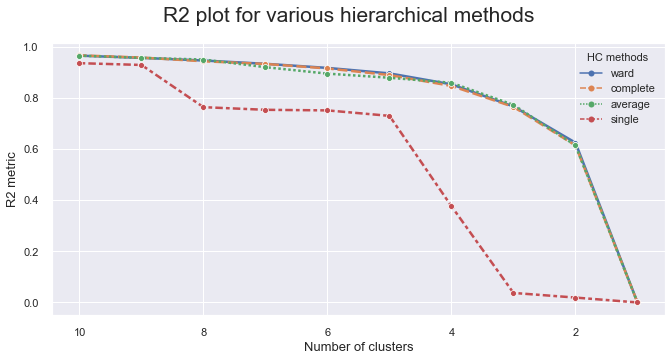

In [80]:
kmeans_hc_clusters1 = kmeans_hc_clusters.groupby("kmeans_hc_labels").mean()

# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack([get_r2_hc(df=kmeans_hc_clusters1, link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
#plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [81]:
#Just to see this dataframe
kmeans_hc_clusters1.head()

index  order_id   user_id  order_number  \
kmeans_hc_labels                                               
0                 1.022260  1.024049 -0.048004     -0.012394   
1                -0.764934 -0.765875  0.673360     -0.010189   
2                 0.066050  0.064494 -0.015877     -0.012809   
3                -1.484157 -1.483203 -0.904781     -0.001316   
4                 1.410659  1.411741 -0.006721      0.020885   

                  order_hour_of_day  add_to_cart_order  department_alcohol  \
kmeans_hc_labels                                                             
0                          0.003210           0.036142            0.000752   
1                          0.006285           0.007073           -0.005649   
2                         -0.016023          -0.000563           -0.004696   
3                         -0.015119          -0.017766            0.005677   
4                         -0.009205          -0.013063           -0.000073   

                  department_babies  department_bakery  department_beverages  \
kmeans_hc_labels                                                               
0                         -0.002262           0.001160             -0.002721   
1                          0.007198          -0.003511             -0.005769   
2                          0.003135          -0.005695              0.002868   
3                         -0.003692          -0.000440              0.004909   
4                          0.005470          -0.001500              0.002189   

                  ...  product_name_spreads  product_name_tea  \
kmeans_hc_labels  ...                                           
0                 ...             -0.000421          0.004365   
1                 ...              0.002527         -0.002526   
2                 ...             -0.000578         -0.002304   
3                 ...             -0.008261          0.004717   
4                 ...              0.002028         -0.001696   

                  product_name_tofu meat alternatives  \
kmeans_hc_labels                                        
0                                           -0.000135   
1                                           -0.002105   
2                                            0.008630   
3                                            0.000127   
4                                            0.000873   

                  product_name_tortillas flat bread  \
kmeans_hc_labels                                      
0                                         -0.001168   
1                                         -0.004367   
2                                         -0.003445   
3                                          0.006210   
4                                         -0.004783   

                  product_name_trail mix snack mix  \
kmeans_hc_labels                                     
0                                         0.003055   
1                                         0.003083   
2                                         0.001502   
3                                        -0.007591   
4                                        -0.006587   

                  product_name_trash bags liners  \
kmeans_hc_labels                                   
0                                      -0.005347   
1                                      -0.004109   
2                                       0.003329   
3                                      -0.003365   
4                                      -0.000215   

                  product_name_vitamins supplements  \
kmeans_hc_labels                                      
0                                         -0.001455   
1                                         -0.005058   
2                                         -0.001246   
3                                          0.005590   
4                                          0.004466   

                  product_name_water seltzer sparkling water  \
kmeans_hc_labels            

In [82]:
#Just to see this dataframe
kmeans_hc_clusters.head()

index  order_id   user_id  order_number  order_hour_of_day  \
0 -1.732050 -1.731718  0.544751     -0.800907          -1.288255   
1 -1.732047 -1.731718  0.544751     -0.800907          -1.288255   
2 -1.732045 -1.731718  0.544751     -0.800907          -1.288255   
3 -1.732043 -1.731718  0.544751     -0.800907          -1.288255   
4 -1.732040 -1.731718  0.544751     -0.800907          -1.288255   

   add_to_cart_order  department_alcohol  department_babies  \
0           0.066985           -0.068348          10.825693   
1           0.206270           -0.068348          -0.092373   
2           0.484839           -0.068348          -0.092373   
3           0.624124           -0.068348          -0.092373   
4          -0.211584           -0.068348          -0.092373   

   department_bakery  department_beverages  ...  product_name_tea  \
0          -0.212675             -0.308929  ...          -0.08845   
1          -0.212675             -0.308929  ...          -0.08845   
2          -0.212675             -0.308929  ...          -0.08845   
3          -0.212675             -0.308929  ...          -0.08845   
4          -0.212675             -0.308929  ...          -0.08845   

   product_name_tofu meat alternatives  product_name_tortillas flat bread  \
0                            -0.066515                          -0.086039   
1                            -0.066515                          -0.086039   
2                            -0.066515                          -0.086039   
3                            -0.066515                          -0.086039   
4                            -0.066515                          -0.086039   

   product_name_trail mix snack mix  product_name_trash bags liners  \
0                         -0.037352                       -0.035063   
1                         -0.037352                       -0.035063   
2                         -0.037352                       -0.035063   
3                         -0.037352                       -0.035063   
4                         -0.037352                       -0.035063   

   product_name_vitamins supplements  \
0                          -0.041175   
1                          -0.041175   
2                          -0.041175   
3                          -0.041175   
4                          -0.041175   

   product_name_water seltzer sparkling water  product_name_white wines  \
0                                   -0.164235                 -0.031542   
1                                   -0.164235                 -0.031542   
2                                   -0.164235                 -0.031542   
3                                   -0.164235                 -0.031542   
4                                   -0.164235                 -0.031542   

   product_name_yogurt  kmeans_hc_labels  
0            -0.196454                12  
1            -0.196454                12  
2            -0.196454                12  
3            -0.196454                12  
4            -0.196454                12  

[5 rows x 162 columns]

In [83]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclabel=hclust.fit_predict(kmeans_hc_clusters1)

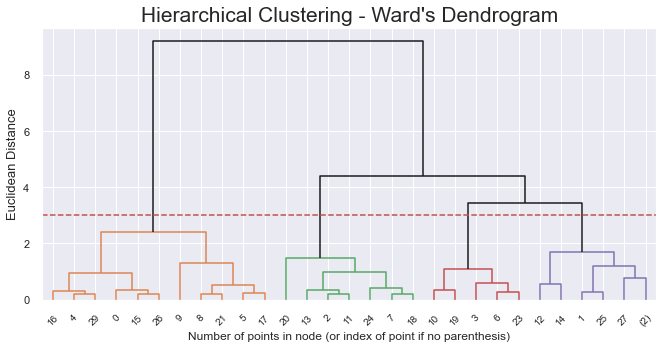

In [84]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 3
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

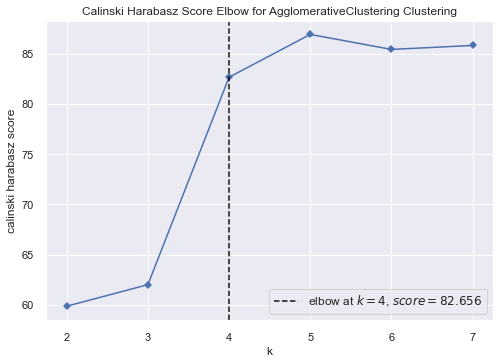

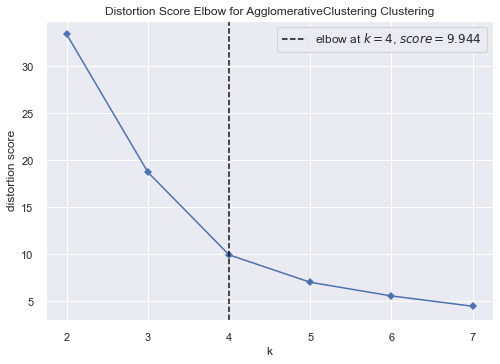

In [94]:
Hclustering = AgglomerativeClustering(linkage=linkage)
plotKElbow(Hclustering,kmeans_hc_clusters1,'calinski_harabasz')
plotKElbow(Hclustering,kmeans_hc_clusters1,'distortion')

In [95]:
kmeans_hc_clustersa = kmeans_hc_clusters1.copy()

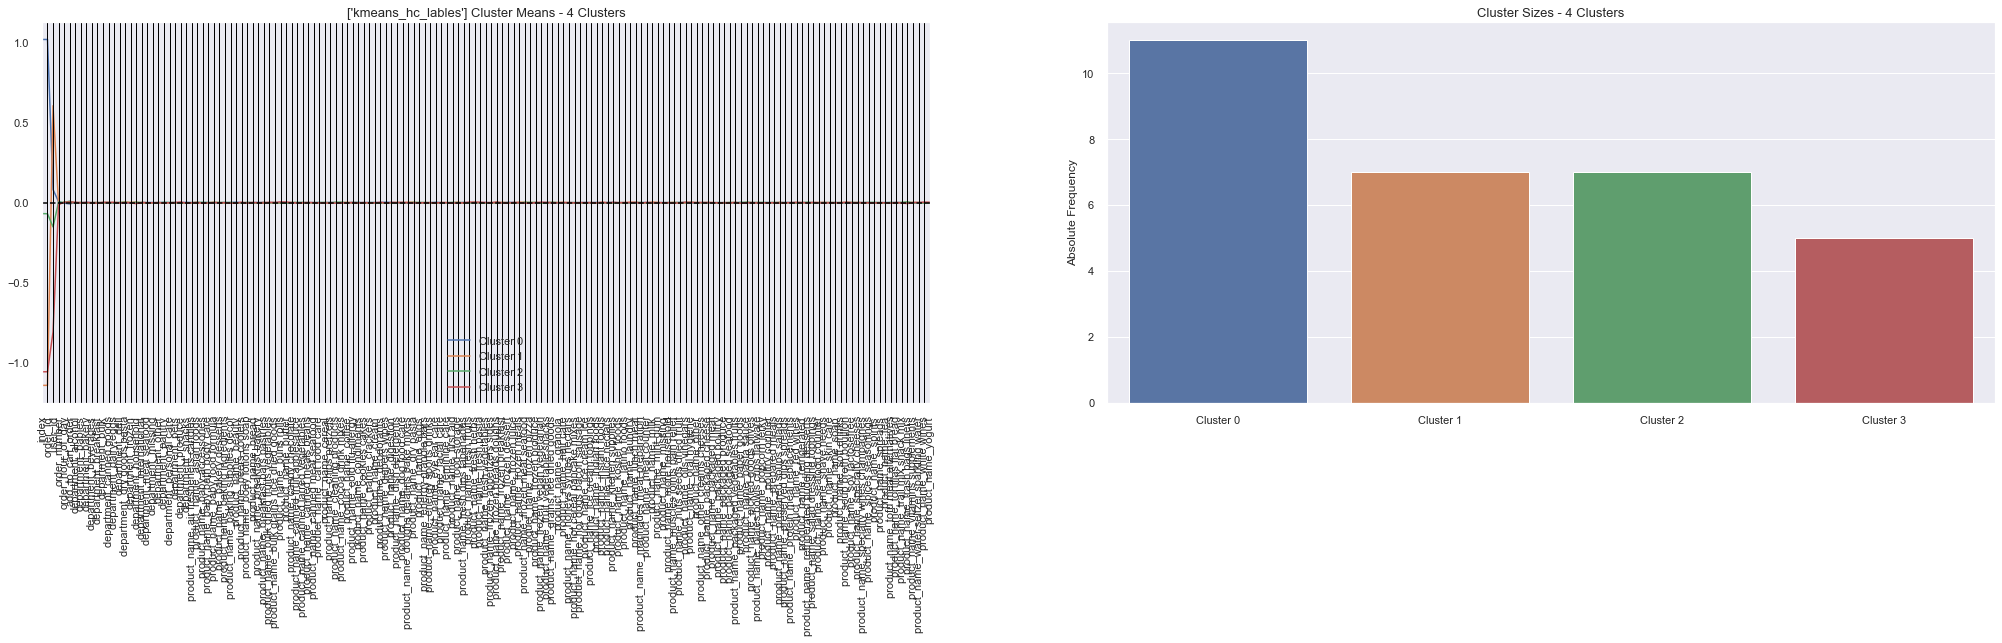

<Figure size 864x144 with 0 Axes>

In [96]:
hc = AgglomerativeClustering(n_clusters=4, linkage=linkage)
labels = hc.fit_predict(kmeans_hc_clusters1)

# Getting the HC labels for each observation in the main dataframe
kmeans_hc_clusters1['kmeans_hc_lables']=labels
cluster_profiles(kmeans_hc_clusters1,["kmeans_hc_lables"], figsize=(35, 7),compar_titles=["K-Means + HC - Value"])

In [97]:
#As the visualization is not explicit, we decided to divide it.

In [98]:
a = kmeans_hc_clustersa.iloc[:, 0:30]
a['kmeans_hc_lables'] = kmeans_hc_clustersa['kmeans_hc_lables']
b = kmeans_hc_clustersa.iloc[:, 30:60]
b['kmeans_hc_lables'] = kmeans_hc_clustersa['kmeans_hc_lables']
c = kmeans_hc_clustersa.iloc[:, 60:90]
c['kmeans_hc_lables'] = kmeans_hc_clustersa['kmeans_hc_lables']
d = kmeans_hc_clustersa.iloc[:, 90:120]
d['kmeans_hc_lables'] = kmeans_hc_clustersa['kmeans_hc_lables']
e = kmeans_hc_clustersa.iloc[:, 120:150]
e['kmeans_hc_lables'] = kmeans_hc_clustersa['kmeans_hc_lables']
f = kmeans_hc_clustersa.iloc[:, 150:]
f['kmeans_hc_lables'] = kmeans_hc_clustersa['kmeans_hc_lables']

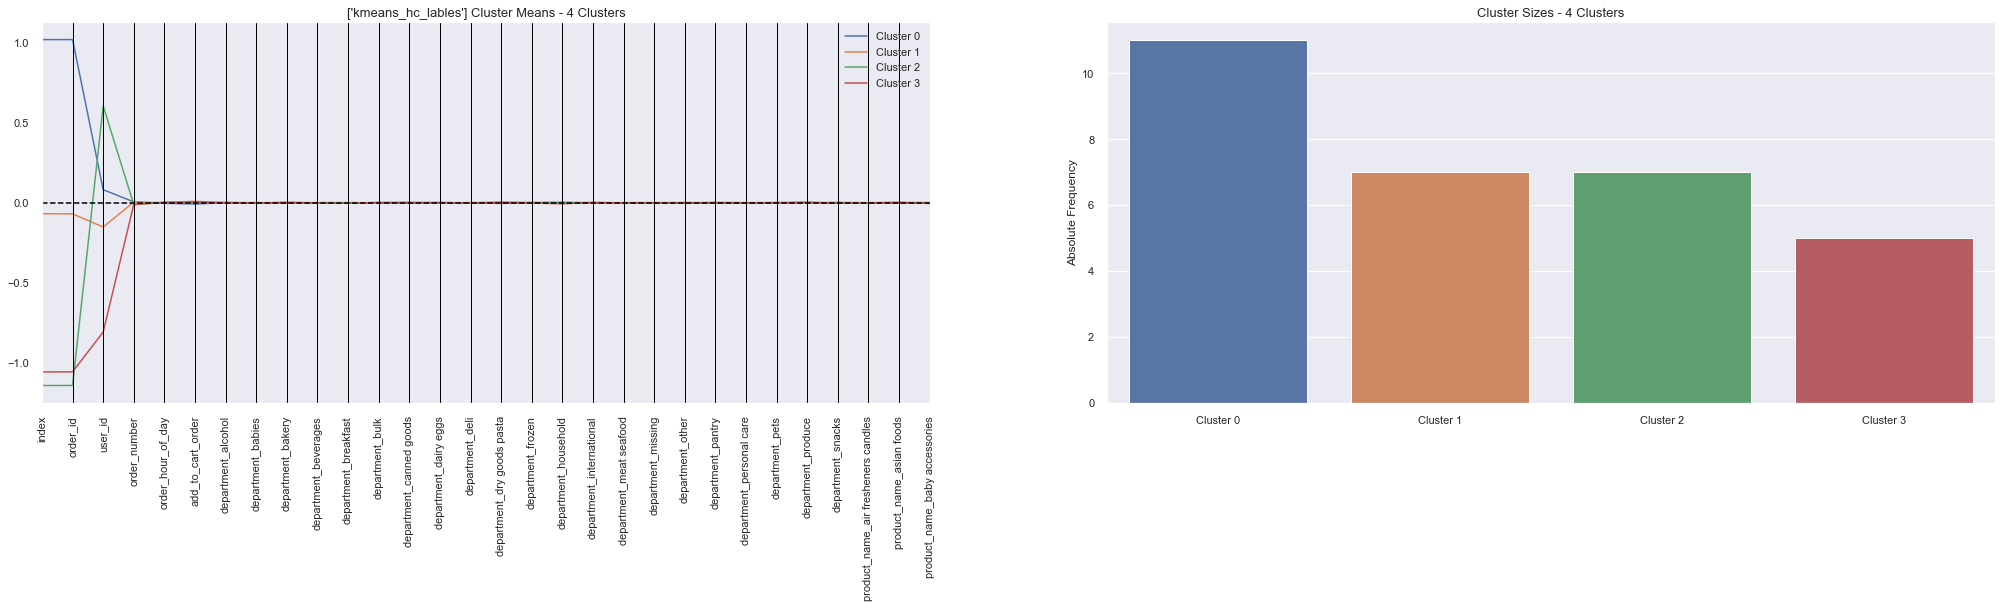

<Figure size 864x144 with 0 Axes>

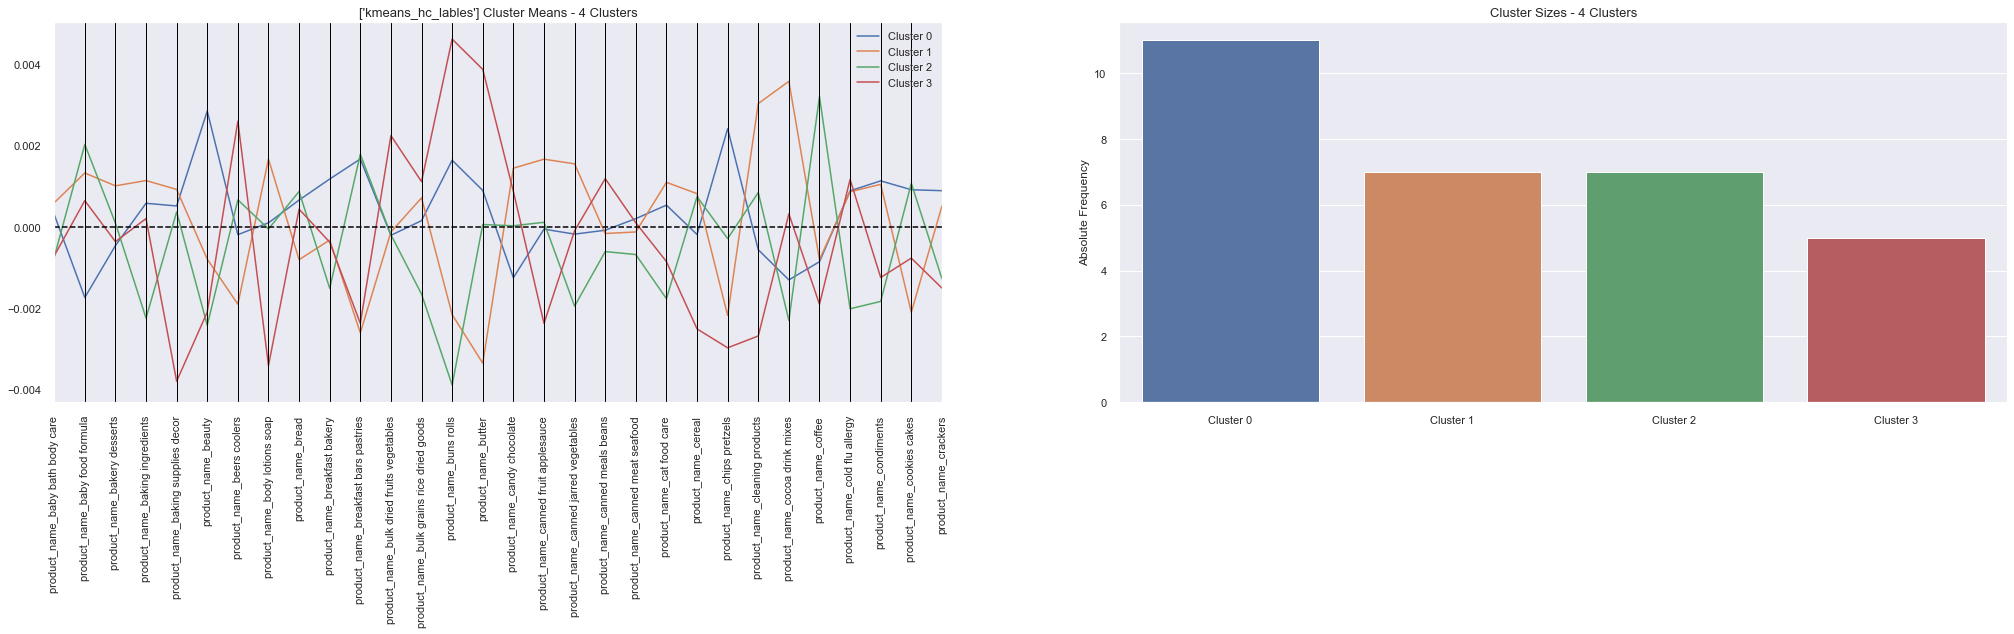

<Figure size 864x144 with 0 Axes>

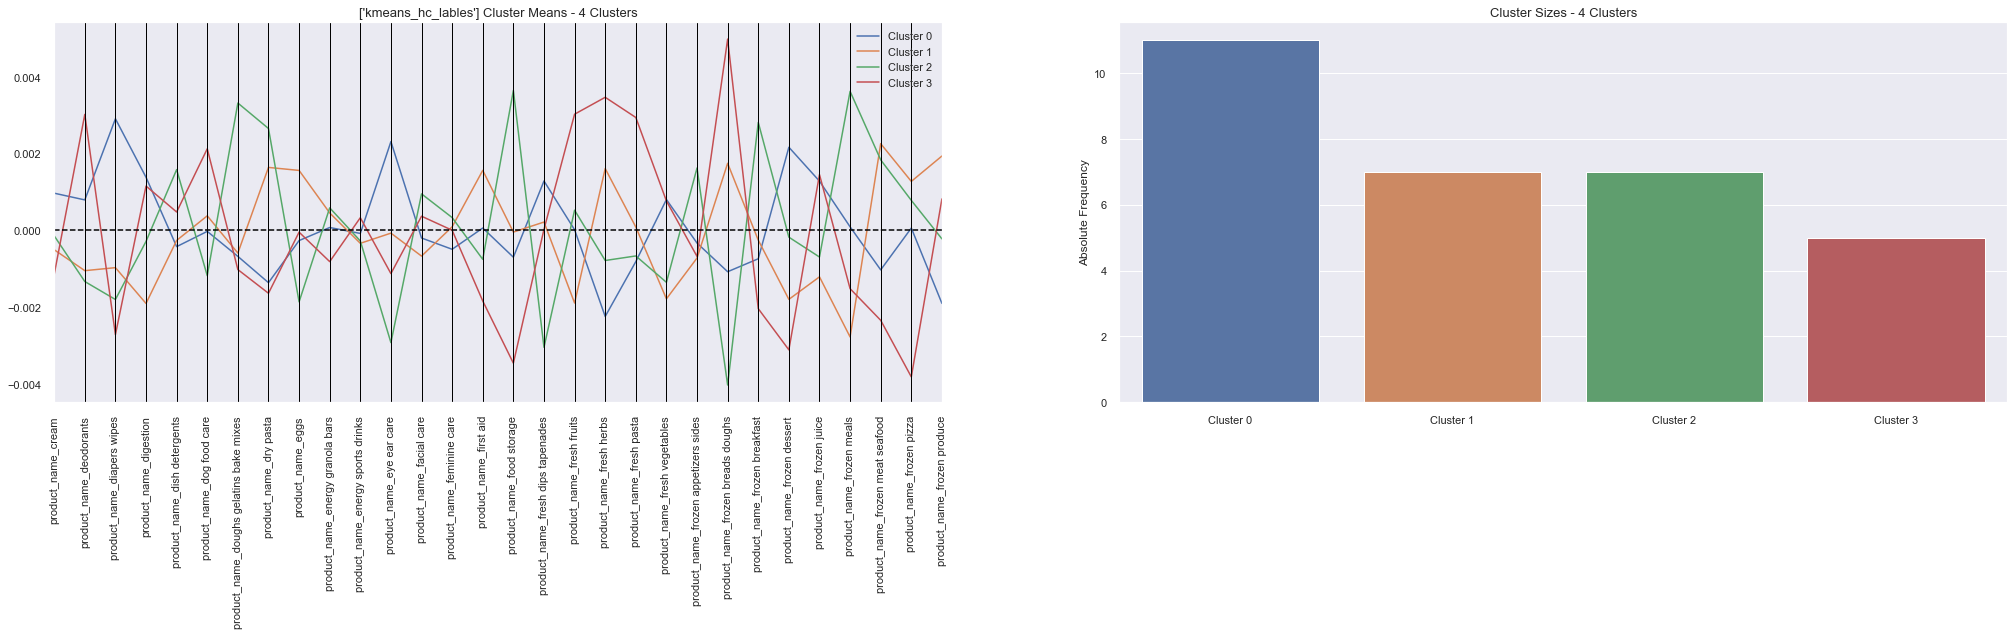

<Figure size 864x144 with 0 Axes>

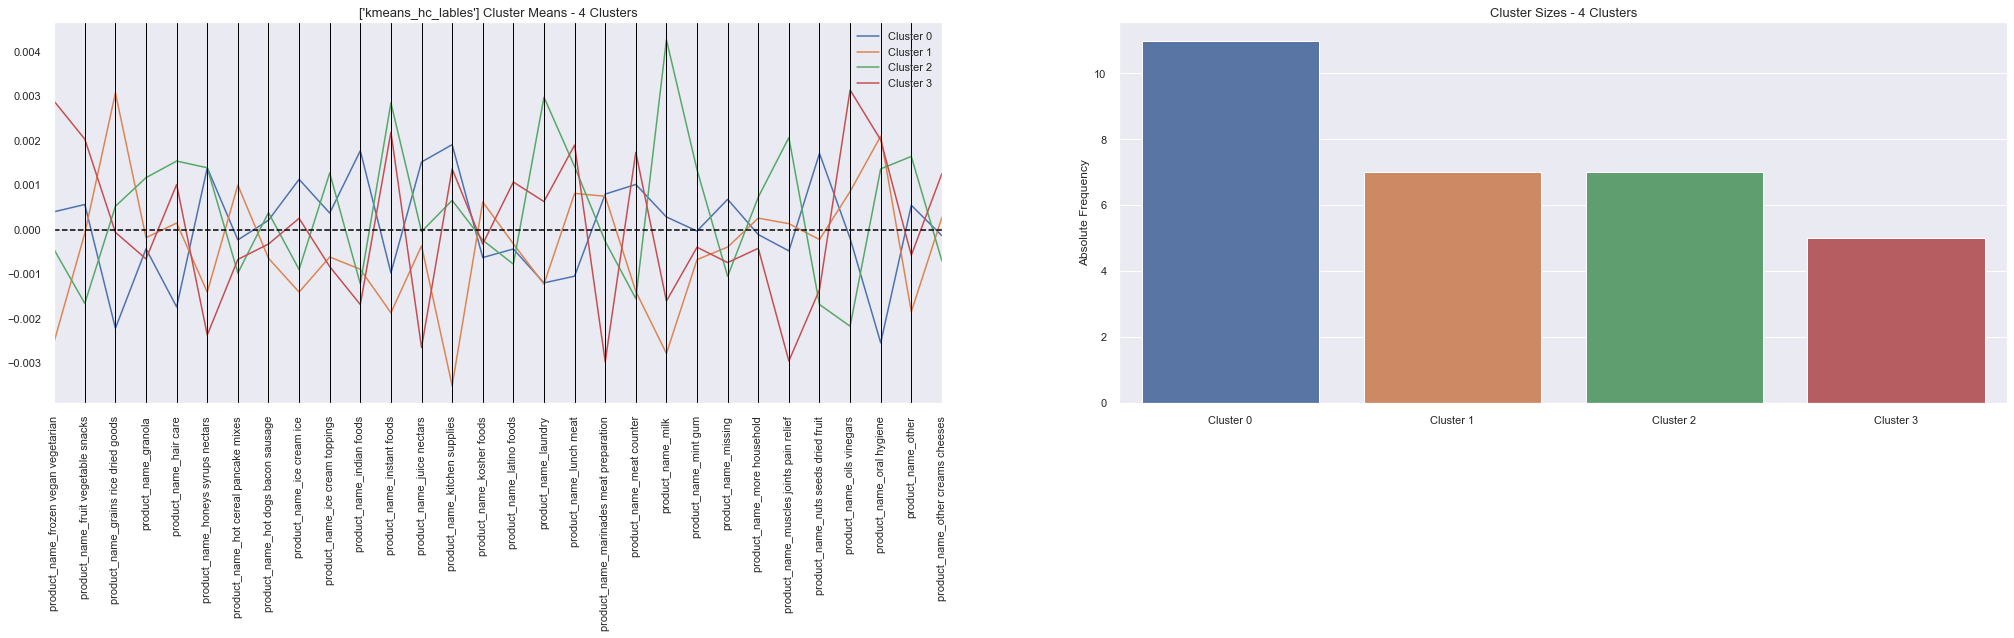

<Figure size 864x144 with 0 Axes>

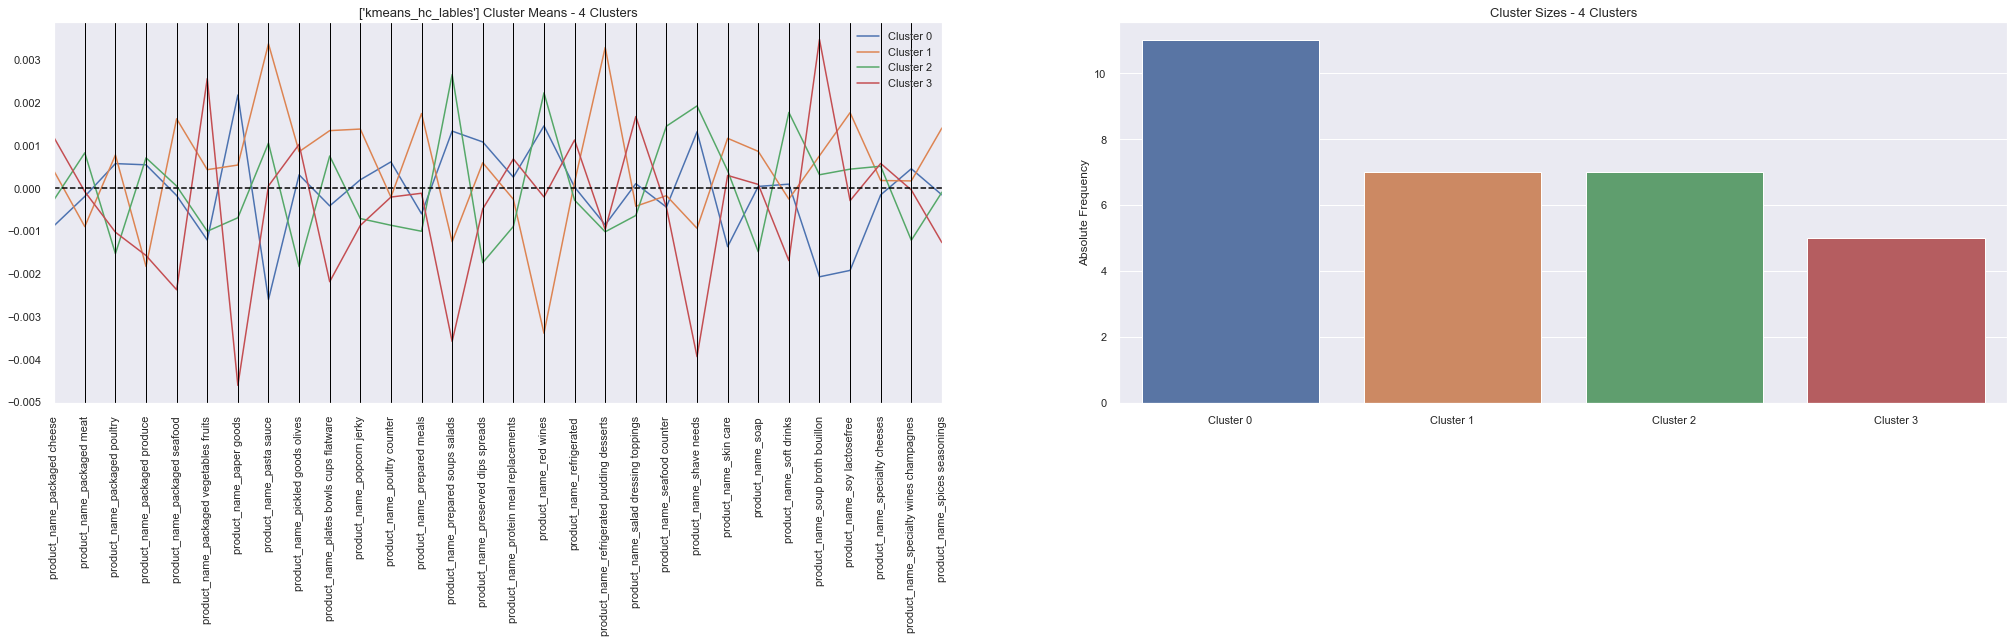

<Figure size 864x144 with 0 Axes>

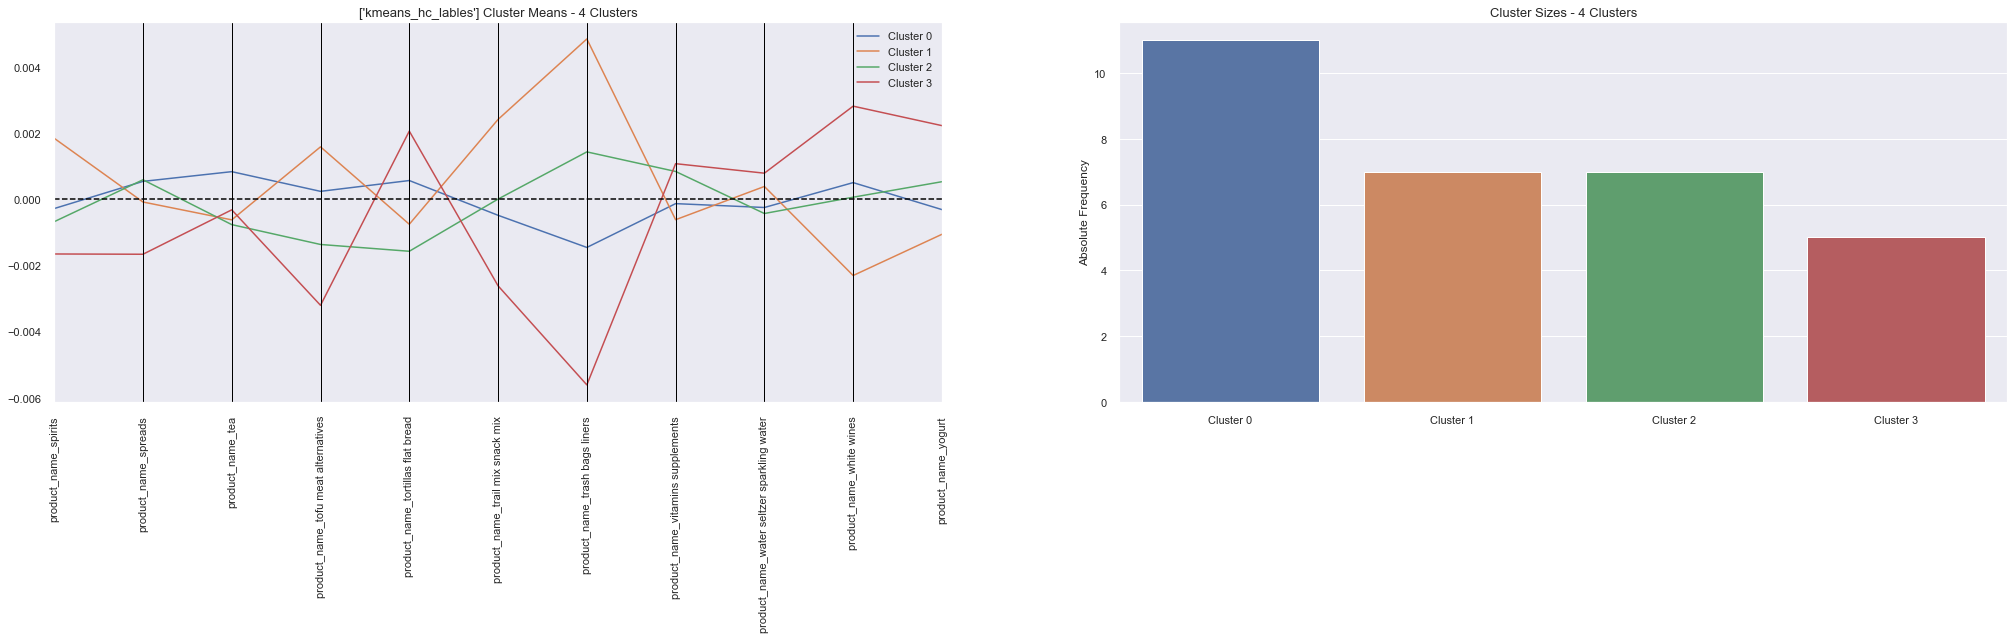

<Figure size 864x144 with 0 Axes>

In [99]:
hc = AgglomerativeClustering(n_clusters=4, linkage=linkage)
labels = hc.fit_predict(kmeans_hc_clusters1)

# Getting the HC labels for each observation in the main dataframe
kmeans_hc_clusters1['kmeans_hc_lables']=labels

#To draw
cluster_profiles(a,["kmeans_hc_lables"], figsize=(35, 7),compar_titles=["K-Means + HC - Value"])
cluster_profiles(b,["kmeans_hc_lables"], figsize=(35, 7),compar_titles=["K-Means + HC - Value"])
cluster_profiles(c,["kmeans_hc_lables"], figsize=(35, 7),compar_titles=["K-Means + HC - Value"])
cluster_profiles(d,["kmeans_hc_lables"], figsize=(35, 7),compar_titles=["K-Means + HC - Value"])
cluster_profiles(e,["kmeans_hc_lables"], figsize=(35, 7),compar_titles=["K-Means + HC - Value"])
cluster_profiles(f,["kmeans_hc_lables"], figsize=(35, 7),compar_titles=["K-Means + HC - Value"])

#### K-means

In [100]:
#To do the one hot enconding on categorical variables
ohc_features_1 = ['department']
ohc_1 = OneHotEncoder(sparse=False)

df_ohc_1 = pd.DataFrame(ohc_1.fit_transform(df_clustering1[ohc_features_1]),
                      index=df_clustering1.index,
                      columns=ohc_1.get_feature_names(ohc_features_1))

In [101]:
df_clustering1.drop(columns='product_name', inplace = True)

In [102]:
df_new_1 = pd.concat([df_clustering1.loc[:, df_clustering1.columns.drop(ohc_features_1)], df_ohc_1], axis=1)

In [103]:
cluster = KMeans(random_state=0)

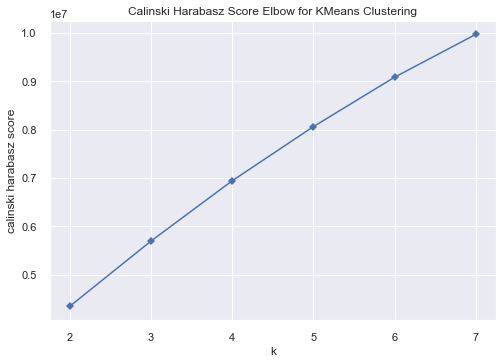

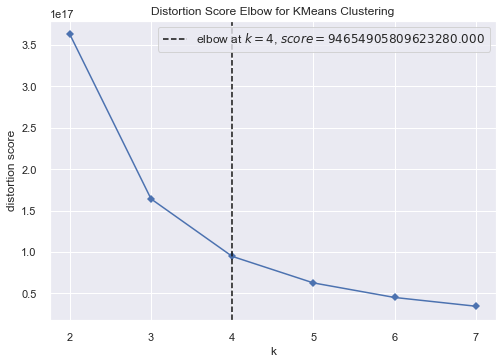

In [104]:
plotKElbow(cluster,df_new_1,'calinski_harabasz')
plotKElbow(cluster,df_new_1,'distortion')

In [105]:
standard_X=pd.DataFrame(StandardScaler().fit(df_new_1).transform(df_new_1),index=df_new_1.index, columns=df_new_1.columns)

In [106]:
standard_X.head()

order_id   user_id  order_number  order_hour_of_day  add_to_cart_order  \
0 -1.731718  0.544751     -0.800907          -1.288255           0.066985   
1 -1.731718  0.544751     -0.800907          -1.288255           0.206270   
2 -1.731718  0.544751     -0.800907          -1.288255           0.484839   
3 -1.731718  0.544751     -0.800907          -1.288255           0.624124   
4 -1.731718  0.544751     -0.800907          -1.288255          -0.211584   

   department_alcohol  department_babies  department_bakery  \
0           -0.068348          10.825693          -0.212675   
1           -0.068348          -0.092373          -0.212675   
2           -0.068348          -0.092373          -0.212675   
3           -0.068348          -0.092373          -0.212675   
4           -0.068348          -0.092373          -0.212675   

   department_beverages  department_breakfast  ...  department_household  \
0             -0.308929             -0.158586  ...             -0.162631   
1             -0.308929             -0.158586  ...             -0.162631   
2             -0.308929             -0.158586  ...             -0.162631   
3             -0.308929             -0.158586  ...             -0.162631   
4             -0.308929             -0.158586  ...             -0.162631   

   department_international  department_meat seafood  department_missing  \
0                 -0.097024                -0.166259           -0.053112   
1                 -0.097024                -0.166259           -0.053112   
2                 -0.097024                -0.166259           -0.053112   
3                 -0.097024                 6.014697           -0.053112   
4                 -0.097024                -0.166259           -0.053112   

   department_other  department_pantry  department_personal care  \
0          -0.03715          -0.264576                 -0.127438   
1          -0.03715          -0.264576                 -0.127438   
2          -0.03715          -0.264576                 -0.127438   
3          -0.03715          -0.264576                 -0.127438   
4          -0.03715          -0.264576                 -0.127438   

   department_pets  department_produce  department_snacks  
0        -0.051257           -0.549364          -0.321837  
1        -0.051257           -0.549364          -0.321837  
2        -0.051257           -0.549364          -0.321837  
3        -0.051257           -0.549364          -0.321837  
4        -0.051257            1.820286          -0.321837  

[5 rows x 26 columns]

In [107]:
standard_X['cluster_labels']=kmeans_cluster(standard_X,3)

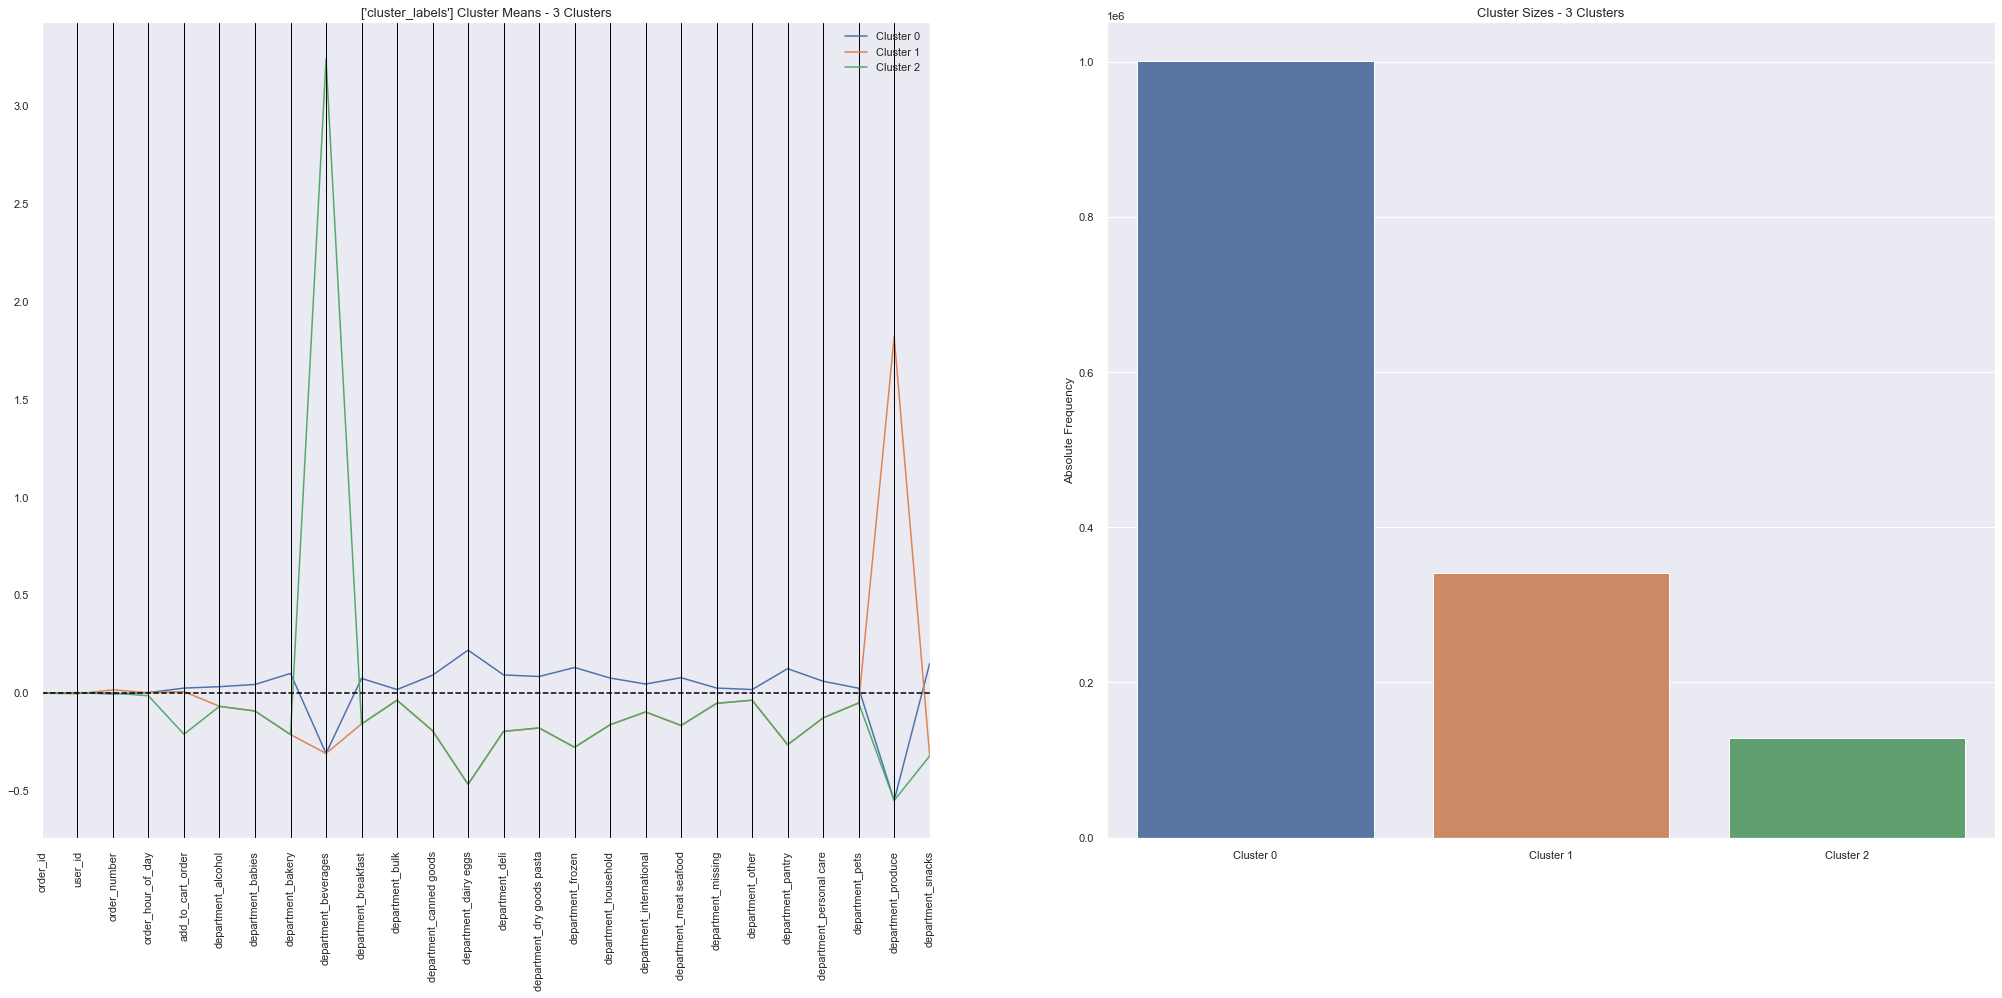

<Figure size 864x144 with 0 Axes>

In [108]:
cluster_profiles(standard_X, ["cluster_labels"], figsize=(35, 15), compar_titles=["K-Means - All Data", "GMM - All Data"])

#### Gaussian Mixture (GMM)

In [109]:
gmm = GaussianMixture(init_params='kmeans', random_state=0)

In [110]:
standard_X['gmm_overall_label']=gmm_cluster(standard_X,4)

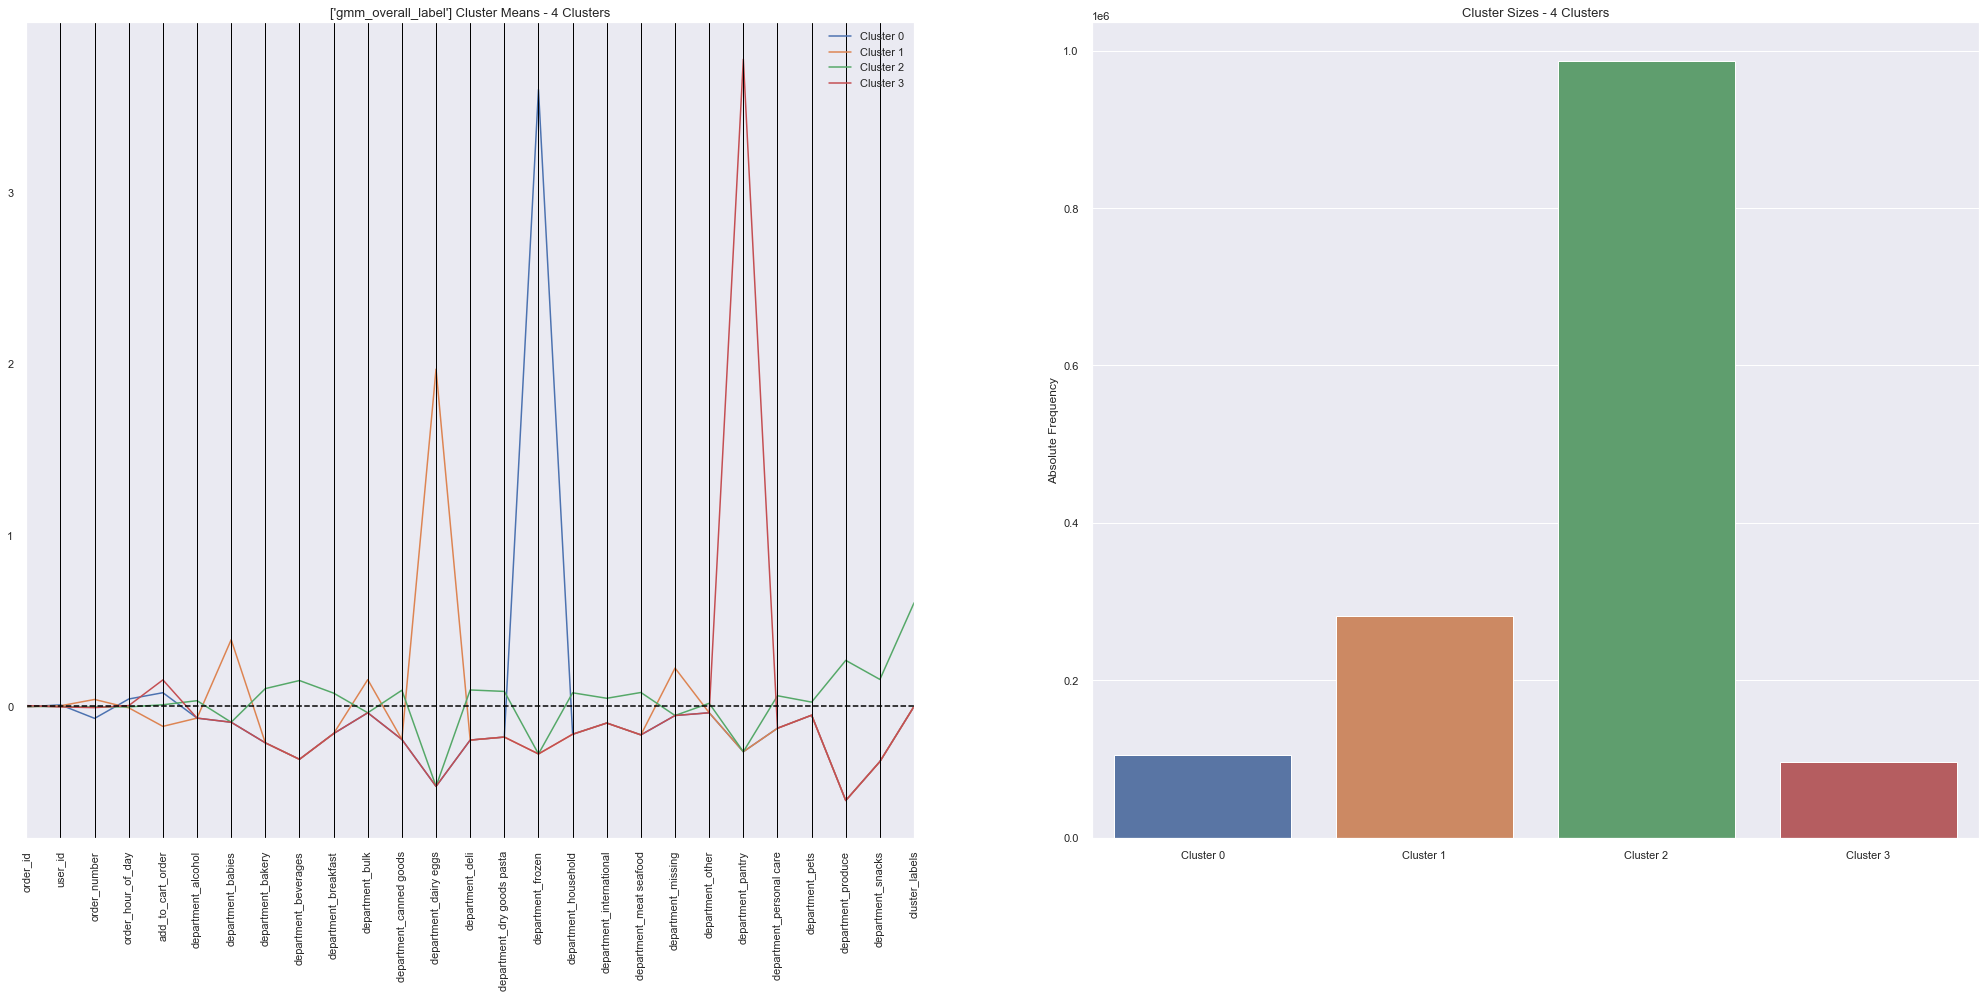

<Figure size 864x144 with 0 Axes>

In [111]:
cluster_profiles(standard_X, ["gmm_overall_label"], figsize=(35, 15), compar_titles=["K-Means - All Data", "GMM - All Data"])

####  MiniBatch Kmeans

In [112]:
MiniBatch = MiniBatchKMeans(n_clusters=None,random_state=0)

In [113]:
standard_minibatch=pd.DataFrame(StandardScaler().fit(df_new_1).transform(df_new_1),index=df_new_1.index, columns=df_new_1.columns)

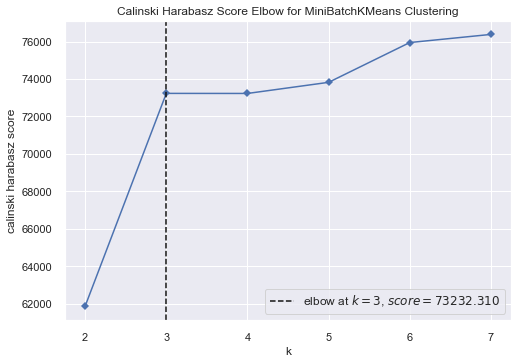

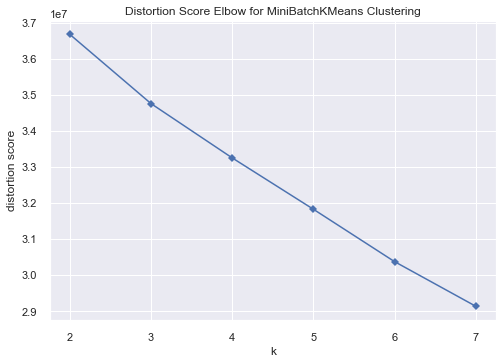

In [114]:
plotKElbow(MiniBatch,standard_minibatch,'calinski_harabasz')
plotKElbow(MiniBatch,standard_minibatch,'distortion')

In [115]:
miniBatchCluster = MiniBatchKMeans(n_clusters=3, init='k-means++', n_init=15, random_state=1)
miniBatch_labels = miniBatchCluster.fit_predict(standard_minibatch)

In [116]:
miniBatch_df=standard_minibatch.copy()
miniBatch_df['miniBatch_labels']=miniBatch_labels

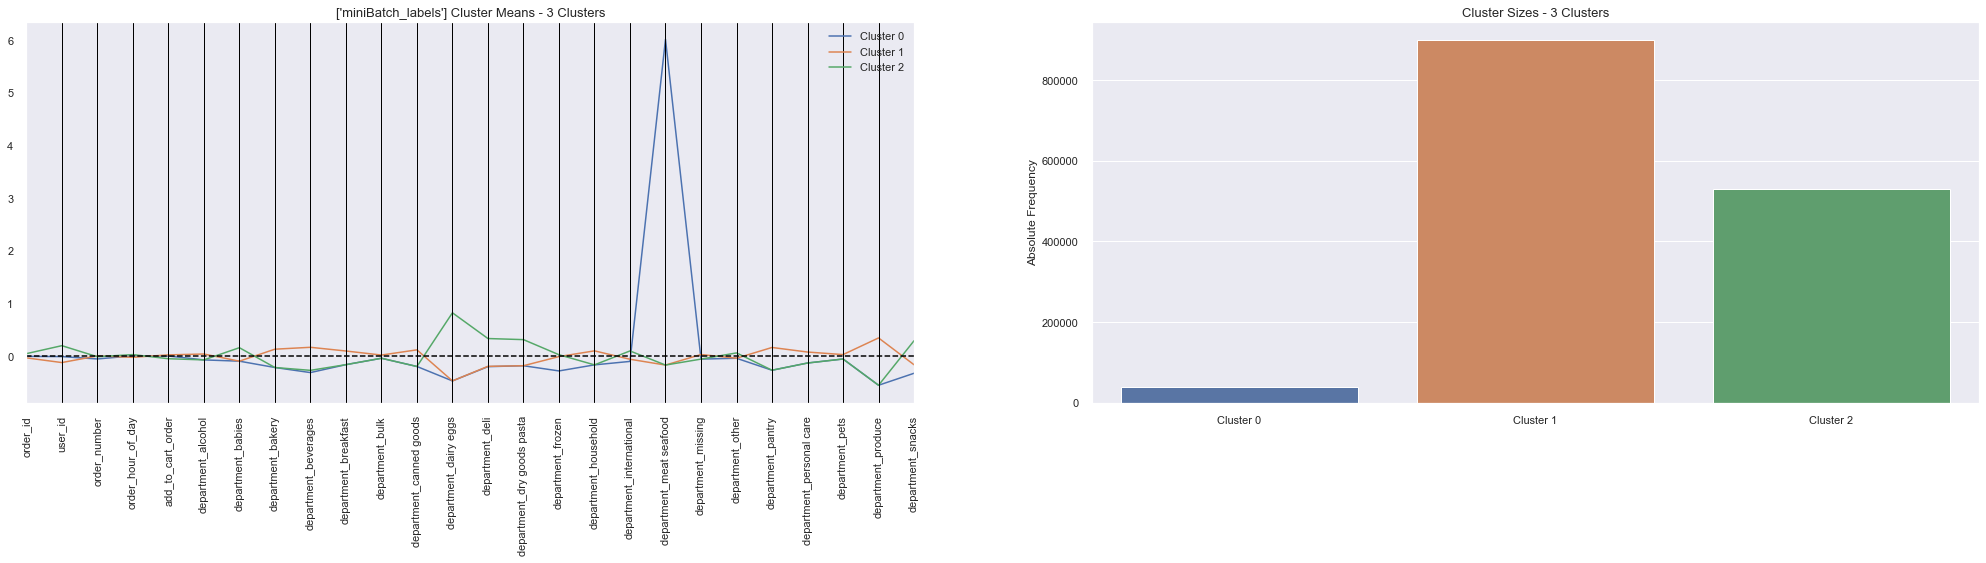

<Figure size 864x144 with 0 Axes>

In [117]:
cluster_profiles(miniBatch_df,["miniBatch_labels"], figsize=(35, 7),compar_titles=["MiniBatchKMeans Clustering"])

#### Self - Organizing Maps

#### K-means with SOM

In [118]:
metric_features = ['order_id', 'user_id', 'order_number', 'order_hour_of_day','add_to_cart_order']

In [119]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

# Notice that the SOM did not converge - We're under a time constraint for this class
sm = sompy.SOMFactory().build(
    df_new_1[metric_features].values, 
    mapsize=(50, 50), 
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)
sm.train(n_job=-1, verbose=False, train_rough_len=100, train_finetune_len=100)

In [120]:
# Coordinates of the units in the input space
sm.get_node_vectors()

array([[2.27385449e+06, 1.51963616e+05, 8.05214081e+01, 1.17896139e+01,
        6.77581309e+00],
       [2.29347782e+06, 1.28919634e+05, 7.88006586e+01, 1.09034915e+01,
        6.46773902e+00],
       [2.38206745e+06, 9.95038178e+04, 7.76378226e+01, 1.04093150e+01,
        6.45243225e+00],
       ...,
       [1.16676138e+06, 1.24778129e+05, 1.44599069e+01, 1.45099735e+01,
        3.62817773e+01],
       [1.36467186e+06, 1.05532419e+05, 1.58173417e+01, 1.38440390e+01,
        3.97878841e+01],
       [1.56909944e+06, 9.51651605e+04, 1.76146634e+01, 1.30329291e+01,
        4.40326652e+01]])

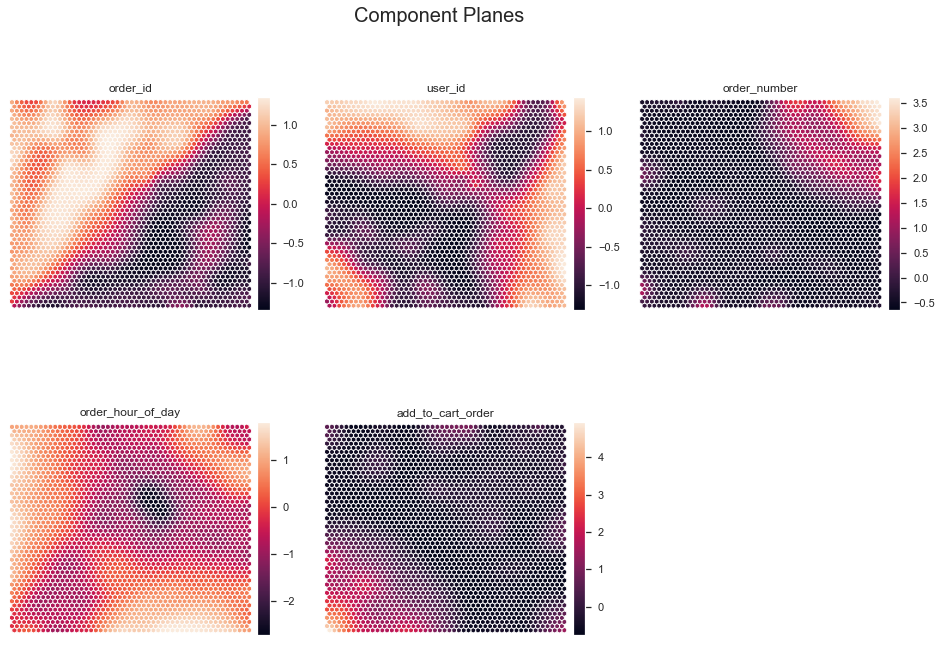

In [121]:
# Component planes on the 50x50 grid
sns.set()
view2D = View2D(12,12,"", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

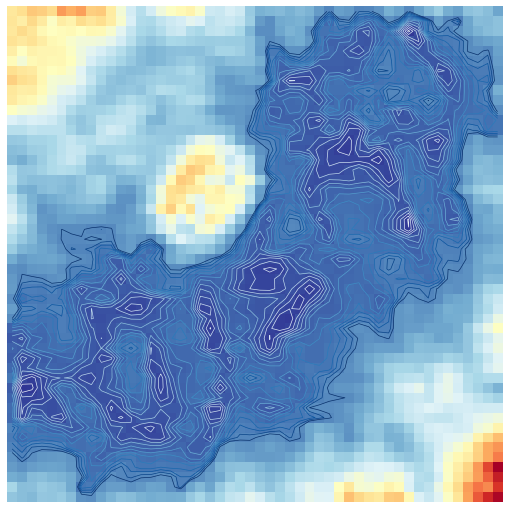

In [122]:
# U-matrix of the 50x50 grid
u = sompy.umatrix.UMatrixView(12, 12, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance2=1, 
    row_normalized=False, 
    show_data=False, 
    contooor=True # Visualize isomorphic curves
)

#### K-Means on top of SOM units

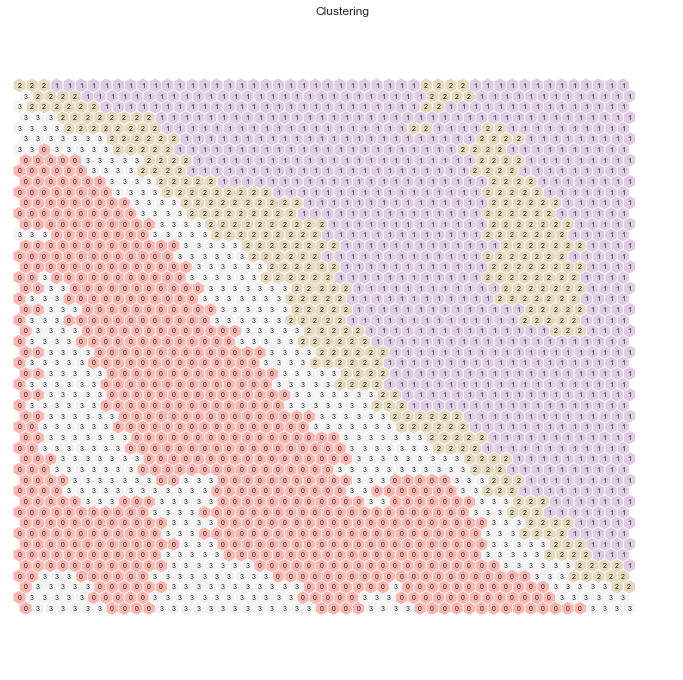

In [123]:
# Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = sm.cluster(kmeans)

hits  = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

#### Final SOM Clustering solution

In [124]:
# Check the nodes and and respective clusters
nodes = sm.get_node_vectors()

df_nodes = pd.DataFrame(nodes, columns=metric_features)
df_nodes['label'] = nodeclus_labels
df_nodes

order_id        user_id  order_number  order_hour_of_day  \
0     2.273854e+06  151963.615594     80.521408          11.789614   
1     2.293478e+06  128919.633906     78.800659          10.903491   
2     2.382067e+06   99503.817791     77.637823          10.409315   
3     2.468246e+06   70940.465142     77.522713          10.496463   
4     2.491311e+06   61503.377096     73.395726          11.182287   
...            ...            ...           ...                ...   
2495  8.543024e+05  149019.114750     13.143857          13.889517   
2496  1.001737e+06  139160.908088     13.671096          14.709898   
2497  1.166761e+06  124778.128811     14.459907          14.509974   
2498  1.364672e+06  105532.419439     15.817342          13.844039   
2499  1.569099e+06   95165.160455     17.614663          13.032929   

      add_to_cart_order  label  
0              6.775813      3  
1              6.467739      3  
2              6.452432      3  
3              6.898870      3  
4              9.487619      0  
...                 ...    ...  
2495          29.776267      1  
2496          32.795737      1  
2497          36.281777      2  
2498          39.787884      2  
2499          44.032665      2  

[2500 rows x 6 columns]

## Exploring Association Rules

#### Functions

In [125]:
# Function to convert rules to coordinates.
def rules_to_coordinates(rules):
    rules['antecedent'] = [','.join(list(x)) for x in rules['antecedents']]
    rules['consequent'] = [','.join(list(x)) for x in rules['consequents']]
    rules['rule'] = rules.index
    return rules[['antecedent','consequent','rule']]

#### Exploration

In [126]:
#To read the 'order_products.csv' dataset
df_1 = pd.read_csv('order_products.csv', usecols=['order_id', 'product_id'])

In [127]:
#To read the 'products.csv' dataset
products = pd.read_csv('products.csv')

In [128]:
# Merge product labels
df_1 = pd.merge(df_1, products, how='left', on='product_id').\
drop(["product_id", "department_id"], axis=1)
df_1.head()

order_id      product_name
0        10      fresh fruits
1        10  fresh vegetables
2        10       fresh herbs
3        10      fresh fruits
4        10  fresh vegetables

In [129]:
# Pivot the data - lines as orders and products as columns
pt = pd.pivot_table(df_1, index='order_id', columns='product_name', 
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
pt.head()

product_name  air fresheners candles  asian foods  baby accessories  \
order_id                                                              
10                               0.0          0.0               0.0   
11                               0.0          0.0               0.0   
28                               0.0          0.0               0.0   
38                               0.0          0.0               0.0   
56                               0.0          0.0               0.0   

product_name  baby bath body care  baby food formula  bakery desserts  \
order_id                                                                
10                            0.0                1.0              0.0   
11                            0.0                0.0              0.0   
28                            0.0                0.0              0.0   
38                            0.0                0.0              0.0   
56                            0.0                0.0              0.0   

product_name  baking ingredients  baking supplies decor  beauty  \
order_id                                                          
10                           0.0                    0.0     0.0   
11                           0.0                    0.0     0.0   
28                           0.0                    0.0     0.0   
38                           0.0                    0.0     0.0   
56                           0.0                    0.0     0.0   

product_name  beers coolers  ...  spreads  tea  tofu meat alternatives  \
order_id                     ...                                         
10                      0.0  ...      0.0  0.0                     0.0   
11                      0.0  ...      0.0  0.0                     0.0   
28                      0.0  ...      1.0  0.0                     0.0   
38                      0.0  ...      0.0  0.0                     0.0   
56                      0.0  ...      0.0  0.0                     0.0   

product_name  tortillas flat bread  trail mix snack mix  trash bags liners  \
order_id                                                                     
10                             0.0                  0.0                0.0   
11                             0.0                  0.0                0.0   
28                             0.0                  0.0                0.0   
38                             0.0                  0.0                0.0   
56                             0.0                  0.0                0.0   

product_name  vitamins supplements  water seltzer sparkling water  \
order_id                                                            
10                             0.0                            0.0   
11                             0.0                            0.0   
28                             0.0                            0.0   
38                             0.0                            0.0   
56                             0.0                            0.0   

product_name  white wines  yogurt  
order_id                           
10                    0.0     0.0  
11                    0.0     0.0  
28                    0.0     1.0  
38                    0.0     0.0  
56                    0.0     0.0  

[5 rows x 134 columns]

In [130]:
# Check in how many orders was product yogurt sold
pt['yogurt'].sum()

52735.0

In [131]:
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 5% of the transactions (more info at http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/)
frequent_itemsets = apriori(pt, min_support=0.05, use_colnames=True)
frequent_itemsets.head()

support              itemsets
0  0.076635  (baking ingredients)
1  0.163865               (bread)
2  0.067765    (breakfast bakery)
3  0.074330              (butter)
4  0.069305     (candy chocolate)

In [132]:
# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50)
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence.head()

antecedents         consequents  \
64                         (fresh fruits, fresh herbs)  (fresh vegetables)   
125  (packaged vegetables fruits, fresh vegetables,...      (fresh fruits)   
115  (milk, fresh vegetables, packaged vegetables f...      (fresh fruits)   
34                                       (fresh herbs)  (fresh vegetables)   
120  (packaged vegetables fruits, fresh vegetables,...      (fresh fruits)   

     antecedent support  consequent support   support  confidence      lift  \
64             0.070135            0.444360  0.061815    0.881372  1.983463   
125            0.087995            0.555995  0.076240    0.866413  1.558311   
115            0.073075            0.555995  0.062535    0.855765  1.539159   
34             0.093005            0.444360  0.078655    0.845707  1.903203   
120            0.081970            0.555995  0.068325    0.833537  1.499180   

     leverage  conviction  
64   0.030650    4.683872  
125  0.027315    3.323711  
115  0.021906    3.078336  
34   0.037327    3.601205  
120  0.022750    2.667284

In [133]:
# Generate the association rules - by lift
rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)
rulesLift.sort_values(by='lift', ascending=False, inplace=True)
rulesLift

antecedents  \
30                                    (fresh herbs)   
29                 (fresh fruits, fresh vegetables)   
31                               (fresh vegetables)   
28                      (fresh fruits, fresh herbs)   
133                      (fresh vegetables, yogurt)   
..                                              ...   
10                            (fresh fruits, bread)   
72   (packaged vegetables fruits, fresh vegetables)   
77                                (packaged cheese)   
37                               (fresh vegetables)   
36                  (fresh fruits, packaged cheese)   

                                        consequents  antecedent support  \
30                 (fresh fruits, fresh vegetables)            0.093005   
29                                    (fresh herbs)            0.317560   
31                      (fresh fruits, fresh herbs)            0.444360   
28                               (fresh vegetables)            0.070135   
133      (fresh fruits, packaged vegetables fruits)            0.144660   
..                                              ...                 ...   
10                     (packaged vegetables fruits)            0.112410   
72                                (packaged cheese)            0.234555   
77   (packaged vegetables fruits, fresh vegetables)            0.230995   
37                  (fresh fruits, packaged cheese)            0.444360   
36                               (fresh vegetables)            0.155900   

     consequent support   support  confidence      lift  leverage  conviction  
30             0.317560  0.061815    0.664642  2.092964  0.032280    2.034958  
29             0.093005  0.061815    0.194656  2.092964  0.032280    1.126221  
31             0.070135  0.061815    0.139110  1.983463  0.030650    1.080121  
28             0.444360  0.061815    0.881372  1.983463  0.030650    4.683872  
133            0.269870  0.076240    0.527029  1.952899  0.037201    1.543710  
..                  ...       ...         ...       ...       ...         ...  
10             0.365415  0.062430    0.555378  1.519855  0.021354    1.427245  
72             0.230995  0.081970    0.349470  1.512891  0.027789    1.182121  
77             0.234555  0.081970    0.354856  1.512891  0.027789    1.186472  
37             0.155900  0.104570    0.235327  1.509475  0.035294    1.103871  
36             0.444360  0.104570    0.670750  1.509475  0.035294    1.687595  

[138 rows x 9 columns]

In [134]:
# High Confidence and high Lift - complementary products
complementary = rulesConfidence[(rulesConfidence['confidence'] >= 0.8) & (rulesConfidence['lift'] >= 1.4)]
complementary

antecedents         consequents  \
64                         (fresh fruits, fresh herbs)  (fresh vegetables)   
125  (packaged vegetables fruits, fresh vegetables,...      (fresh fruits)   
115  (milk, fresh vegetables, packaged vegetables f...      (fresh fruits)   
34                                       (fresh herbs)  (fresh vegetables)   
120  (packaged vegetables fruits, fresh vegetables,...      (fresh fruits)   
100               (packaged vegetables fruits, yogurt)      (fresh fruits)   
96       (soy lactosefree, packaged vegetables fruits)      (fresh fruits)   
85                          (fresh vegetables, yogurt)      (fresh fruits)   
90                  (milk, packaged vegetables fruits)      (fresh fruits)   
87        (frozen produce, packaged vegetables fruits)      (fresh fruits)   
51                 (bread, packaged vegetables fruits)      (fresh fruits)   
81                 (soy lactosefree, fresh vegetables)      (fresh fruits)   
61                  (packaged vegetables fruits, eggs)      (fresh fruits)   

     antecedent support  consequent support   support  confidence      lift  \
64             0.070135            0.444360  0.061815    0.881372  1.983463   
125            0.087995            0.555995  0.076240    0.866413  1.558311   
115            0.073075            0.555995  0.062535    0.855765  1.539159   
34             0.093005            0.444360  0.078655    0.845707  1.903203   
120            0.081970            0.555995  0.068325    0.833537  1.499180   
100            0.127910            0.555995  0.105790    0.827066  1.487542   
96             0.081385            0.555995  0.066960    0.822756  1.479790   
85             0.144660            0.555995  0.118420    0.818609  1.472332   
90             0.107425            0.555995  0.087450    0.814056  1.464143   
87             0.066985            0.555995  0.054415    0.812346  1.461067   
51             0.077055            0.555995  0.062430    0.810201  1.457208   
81             0.094120            0.555995  0.075620    0.803442  1.445053   
61             0.068650            0.555995  0.055045    0.801821  1.442137   

     leverage  conviction  
64   0.030650    4.683872  
125  0.027315    3.323711  
115  0.021906    3.078336  
34   0.037327    3.601205  
120  0.022750    2.667284  
100  0.034673    2.567481  
96   0.021710    2.505050  
85   0.037990    2.447781  
90   0.027722    2.387847  
87   0.017172    2.366084  
51   0.019588    2.339337  
81   0.023290    2.258905  
61   0.016876    2.240422

In [135]:
# Substitue products
rulesLift2 = association_rules(frequent_itemsets, metric="lift", min_threshold=0.0)
rulesLift2.sort_values(by='lift', ascending=True, inplace=True)
rulesLift2.head(10)

antecedents                       consequents  \
110   (water seltzer sparkling water)                (fresh vegetables)   
111                (fresh vegetables)   (water seltzer sparkling water)   
231  (fresh fruits, fresh vegetables)   (water seltzer sparkling water)   
234   (water seltzer sparkling water)  (fresh fruits, fresh vegetables)   
82                     (fresh fruits)   (water seltzer sparkling water)   
83    (water seltzer sparkling water)                    (fresh fruits)   
133   (water seltzer sparkling water)      (packaged vegetables fruits)   
132      (packaged vegetables fruits)   (water seltzer sparkling water)   
59                    (ice cream ice)                    (fresh fruits)   
58                     (fresh fruits)                   (ice cream ice)   

     antecedent support  consequent support   support  confidence      lift  \
110            0.193005            0.444360  0.083355    0.431880  0.971915   
111            0.444360            0.193005  0.083355    0.187584  0.971915   
231            0.317560            0.193005  0.063235    0.199128  1.031723   
234            0.193005            0.317560  0.063235    0.327634  1.031723   
82             0.555995            0.193005  0.111045    0.199723  1.034807   
83             0.193005            0.555995  0.111045    0.575348  1.034807   
133            0.193005            0.365415  0.073715    0.381933  1.045204   
132            0.365415            0.193005  0.073715    0.201730  1.045204   
59             0.110510            0.555995  0.064485    0.583522  1.049509   
58             0.555995            0.110510  0.064485    0.115981  1.049509   

     leverage  conviction  
110 -0.002409    0.978033  
111 -0.002409    0.993328  
231  0.001944    1.007645  
234  0.001944    1.014983  
82   0.003735    1.008395  
83   0.003735    1.045573  
133  0.003188    1.026725  
132  0.003188    1.010929  
59   0.003042    1.066094  
58   0.003042    1.006189

In [136]:
#Low confidence and Low lift - Substituts products
subtituts = rulesLift2[(rulesLift2['confidence'] <= 0.5) & (rulesLift2['lift'] <= 1.1)]
subtituts

antecedents  \
110             (water seltzer sparkling water)   
111                          (fresh vegetables)   
231            (fresh fruits, fresh vegetables)   
234             (water seltzer sparkling water)   
82                               (fresh fruits)   
133             (water seltzer sparkling water)   
132                (packaged vegetables fruits)   
58                               (fresh fruits)   
92                           (fresh vegetables)   
93                              (ice cream ice)   
285  (fresh fruits, packaged vegetables fruits)   
288             (water seltzer sparkling water)   
20                           (fresh vegetables)   
21                             (chips pretzels)   

                                    consequents  antecedent support  \
110                          (fresh vegetables)            0.193005   
111             (water seltzer sparkling water)            0.444360   
231             (water seltzer sparkling water)            0.317560   
234            (fresh fruits, fresh vegetables)            0.193005   
82              (water seltzer sparkling water)            0.555995   
133                (packaged vegetables fruits)            0.193005   
132             (water seltzer sparkling water)            0.365415   
58                              (ice cream ice)            0.555995   
92                              (ice cream ice)            0.444360   
93                           (fresh vegetables)            0.110510   
285             (water seltzer sparkling water)            0.269870   
288  (fresh fruits, packaged vegetables fruits)            0.193005   
20                             (chips pretzels)            0.444360   
21                           (fresh vegetables)            0.169435   

     consequent support   support  confidence      lift  leverage  conviction  
110            0.444360  0.083355    0.431880  0.971915 -0.002409    0.978033  
111            0.193005  0.083355    0.187584  0.971915 -0.002409    0.993328  
231            0.193005  0.063235    0.199128  1.031723  0.001944    1.007645  
234            0.317560  0.063235    0.327634  1.031723  0.001944    1.014983  
82             0.193005  0.111045    0.199723  1.034807  0.003735    1.008395  
133            0.365415  0.073715    0.381933  1.045204  0.003188    1.026725  
132            0.193005  0.073715    0.201730  1.045204  0.003188    1.010929  
58             0.110510  0.064485    0.115981  1.049509  0.003042    1.006189  
92             0.110510  0.051995    0.117011  1.058827  0.002889    1.007362  
93             0.444360  0.051995    0.470500  1.058827  0.002889    1.049368  
285            0.193005  0.056550    0.209545  1.085699  0.004464    1.020925  
288            0.269870  0.056550    0.292998  1.085699  0.004464    1.032712  
20             0.169435  0.082245    0.185086  1.092374  0.006955    1.019206  
21             0.444360  0.082245    0.485407  1.092374  0.006955    1.079767

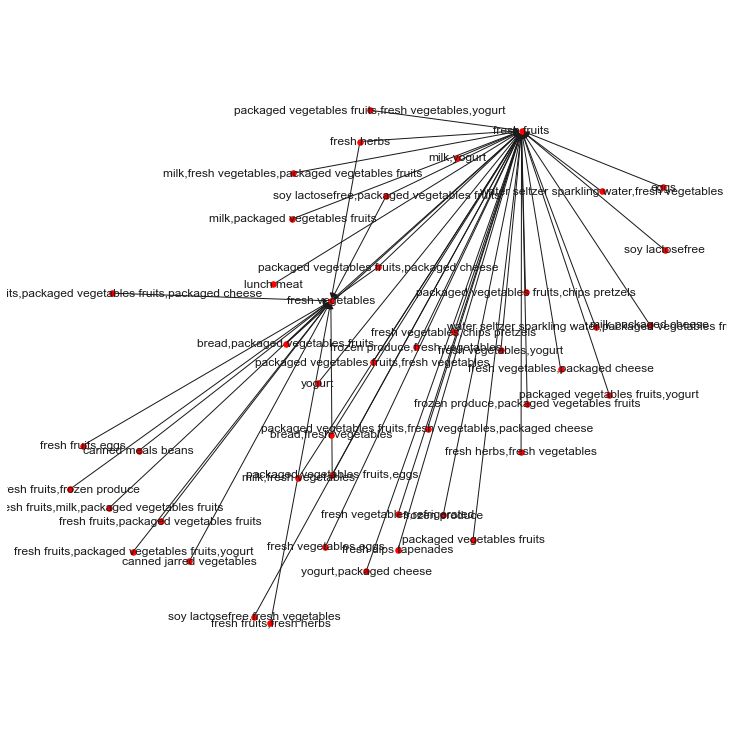

In [137]:
### Plot a basic network graph of the top 50 confidence rules
# Create a copy of the rules and transform the frozensets to strings

rulesToPlot = rulesConfidence.copy(deep=True)
rulesToPlot['LHS'] = [','.join(list(x)) for x in rulesToPlot['antecedents']]
rulesToPlot['RHS'] = [','.join(list(x)) for x in rulesToPlot['consequents']]
# Remove duplicate if reversed rules
rulesToPlot['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot.LHS, rulesToPlot.RHS)]
rulesToPlot['sortedRow'] = rulesToPlot['sortedRow'].astype(str)
rulesToPlot.drop_duplicates(subset=['sortedRow'], inplace=True)
# Plot
rulesToPlot=rulesToPlot[:50]
fig = plt.figure(figsize=(10, 10)) 

G = nx.from_pandas_edgelist(rulesToPlot, 'LHS', 'RHS', create_using=nx.DiGraph())  #WITH DIRECTION
# Each node is an itemset (either source or target) and the edges connect the itemsets if they consist of a high confidence rule
nx.draw(G, with_labels=True, node_size=30, node_color="red", pos=nx.spring_layout(G))
plt.axis('equal')
plt.show()
fig.savefig('figure.svg')

#### As we can see, we applied the direction from source to target in the network graph !

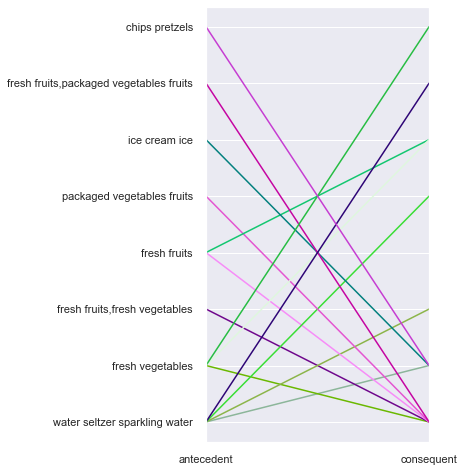

In [138]:
#To show the substituts products
# Convert rules into coordinates suitable for use in a parallel coordinates plot
coords = rules_to_coordinates(subtituts)

# Generate parallel coordinates plot
plt.figure(figsize=(4,8))
parallel_coordinates(coords, 'rule')
plt.legend([])
plt.grid(True)
plt.show()

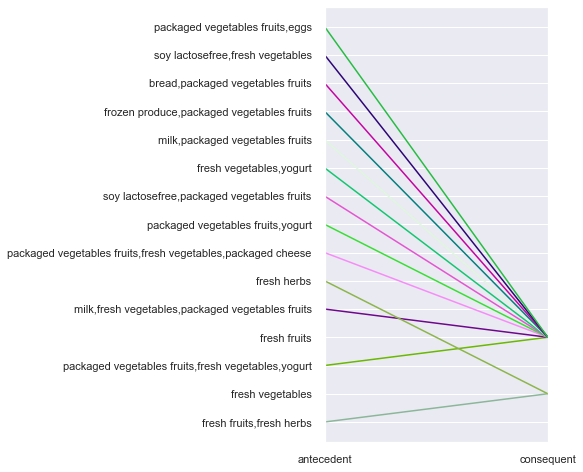

In [139]:
#To show the complementary products
# Convert rules into coordinates suitable for use in a parallel coordinates plot
coords = rules_to_coordinates(complementary)

# Generate parallel coordinates plot
plt.figure(figsize=(4,8))
parallel_coordinates(coords, 'rule')
plt.legend([])
plt.grid(True)
plt.show()

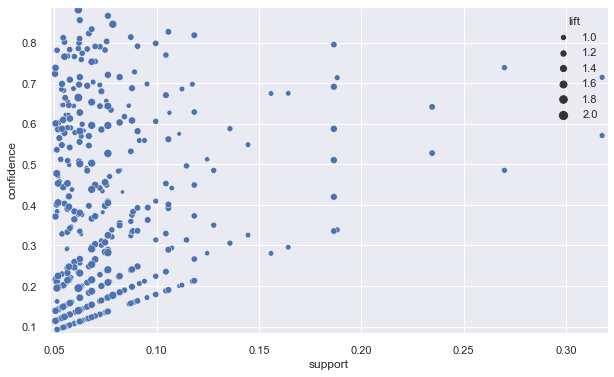

In [140]:
#To show a scatterplot 
plt.figure(figsize=(10,6))
sns.scatterplot(x = "support", y = "confidence", 
                size = "lift", data = rulesLift2)
plt.margins(0.01,0.01)
plt.show()